# Detecting Victim Groupings in Baltimore Crime Data

## Goal 

The purpose of this analysis is to attempt to detect hidden groupings within crime victim data from Baltimore City. We will then assess the information from these groupings as well as join demographic info to creat victim profiles. These profiles will help police target individuals for crime prevention efforts and assist in crime investigation.

## The Data

The primary dataset which will be used in this analysis is the victim based part 1 crime table, produced by the Baltimore City Police Department. It reports crimes based upon each victim, rather than occurance, and thus each row can be thought of as a victim. The dataset at the time I accessed it consisted of almost 280,000 records and 22 columns. Due to its volume, I decided to focus on the most recent year of data. 
https://data.baltimorecity.gov/api/views/wsfq-mvij/rows.csv?accessType=DOWNLOAD

In the second half of the analysis a shapefile containing census data for each neighborhood within Baltimore is joined to this crime data. It was compiled using data from the most recent 2010 census and is part of a program managed by the city known as 'vital signs'
https://data.baltimorecity.gov/api/views/2ktz-dadz/rows.csv?accessType=DOWNLOAD

----

In [281]:
#Import all reuired libraries
import pandas as pd
import datetime
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing
import category_encoders as ce 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

## Obtain data and preporcessing

In [282]:
#Crime = pd.read_csv('https://data.baltimorecity.gov/api/views/wsfq-mvij/rows.csv?accessType=DOWNLOAD')
Crime = pd.read_csv('Crime.csv',sep=",")

In [283]:
print(Crime.columns)

Index(['Unnamed: 0', 'CrimeDate', 'CrimeTime', 'CrimeCode', 'Location',
       'Description', 'Inside/Outside', 'Weapon', 'Post', 'District',
       'Neighborhood', 'Longitude', 'Latitude', 'Location 1', 'Premise',
       'vri_name1', 'Total Incidents'],
      dtype='object')


Create some time series features

In [284]:
Crime['Year'] = pd.DatetimeIndex(Crime['CrimeDate']).year
Crime['Month'] = pd.DatetimeIndex(Crime['CrimeDate']).month
Crime['WeekdayName'] = (pd.to_datetime(Crime['CrimeDate'])).dt.day_name()
Crime['dayofyear']=pd.to_datetime(Crime['CrimeDate']).dt.dayofyear
Crime['HourofDay'] = Crime['CrimeTime'].astype(str).str[0:2]

In [285]:
#Filter out anything older than 2014
Crime=Crime[(Crime['Year'] >= 2014)]

In [286]:
Crime.head(3)

Unnamed: 0   CrimeDate CrimeTime CrimeCode             Location  \
0           0  10/31/2020  10:57:00        3B  1 BL N SMALLWOOD ST   
1           1  10/31/2020  18:19:00        4E    1600 E FAYETTE ST   
2           2  10/31/2020  14:00:00        6J      1500 WINFORD RD   

        Description Inside/Outside Weapon   Post   District  \
0  ROBBERY - STREET              O    NaN  714.0    WESTERN   
1    COMMON ASSAULT            NaN    NaN  212.0  SOUTHEAST   
2           LARCENY              O    NaN  415.0  NORTHEAST   

                      Neighborhood  Longitude   Latitude  Location 1  \
0  PENROSE/FAYETTE STREET OUTREACH -76.651406  39.288013         NaN   
1                  DUNBAR-BROADWAY -76.595851  39.293719         NaN   
2                     PERRING LOCH -76.588293  39.353147         NaN   

      Premise vri_name1  Total Incidents  Year  Month WeekdayName  dayofyear  \
0      STREET       NaN                1  2020     10    Saturday        305   
1         NaN       NaN                1  2020     10    Saturday        305   
2  PORCH/DECK       NaN                1  2020     10    Saturday        305   

  HourofDay  
0        10  
1        18  
2        14

In [287]:
#Drop unwanted cols
Crime=Crime.drop(['CrimeDate','CrimeTime','CrimeCode','Location','District','Post','Location 1','vri_name1','Total Incidents','Unnamed: 0'],axis=1)

In [289]:
#Check for null values
Crime.isnull().sum()

Description            0
Inside/Outside     39342
Weapon            251002
Neighborhood         823
Longitude            311
Latitude             311
Premise            39591
Year                   0
Month                  0
WeekdayName            0
dayofyear              0
HourofDay              0
dtype: int64

In [290]:
#Create a new feature where we classify crimes as either property or violent crime

Crime['CrimeType'] = Crime['Description']

#Group all Crimes into 2 categories property, and violent and rename the row value name as one of these
searchfor=['LARCENY','LARCENY FROM AUTO','AUTO THEFT','BURGLARY','ARSON']
filt = Crime['Description'].str.contains('|'.join(searchfor), na=False)
Crime.loc[Crime['Description'].str.contains('|'.join(searchfor), na=False), 'Description'] = 'Property Crime'

searchfor=['AGG. ASSAULT','COMMON ASSAULT','ROBBERY - STREET','ROBBERY - COMMERCIAL','ROBBERY - CARJACKING','ROBBERY - RESIDENCE','RAPE','HOMICIDE','SHOOTING']
filt = Crime['Description'].str.contains('|'.join(searchfor), na=False)
Crime.loc[Crime['Description'].str.contains('|'.join(searchfor), na=False), 'Description'] = 'Violent Crime'


In [291]:
Crime.Description.value_counts()

Property Crime    187175
Violent Crime     132193
Name: Description, dtype: int64

In [292]:
#Recode not consistent
Crime['Inside/Outside'].replace(to_replace =['O','Outside'], value =0,inplace=True)
Crime['Inside/Outside'].replace(to_replace =['I','Inside'], value =1,inplace=True)

In [293]:
#Null values indicate no weapon used in crime
Crime['Weapon'] = Crime['Weapon'].fillna(0)

In [294]:
Crime=Crime.dropna(axis=0,how='any')

In [295]:
Crime.isnull().sum()

Description       0
Inside/Outside    0
Weapon            0
Neighborhood      0
Longitude         0
Latitude          0
Premise           0
Year              0
Month             0
WeekdayName       0
dayofyear         0
HourofDay         0
CrimeType         0
dtype: int64

In [296]:
print(Crime.shape)
Crime=Crime.dropna(axis=0,how='any')
Crime=Crime.dropna(axis=1,how='any')
Crime=Crime[(Crime['HourofDay'] != 'na')]
pd.set_option('display.max_columns', None)
print(Crime.shape)

(279119, 13)
(279093, 13)


Trimming the df for one year of data due to processing limitations of my machine

In [297]:
SelectOut=Crime[Crime['Year']==2020]
#SelectOut=SelectOut.drop(['Longitude','Latitude','Year','Inside/Outside','Weapon','Month','dayofyear'],axis=1)

#No longer needed for 1 year of data, month covered by day of year
SelectOut=SelectOut.drop(['Year','Month'],axis=1)
SelectOut.head(3)

Description  Inside/Outside   Weapon                     Neighborhood  \
0   Violent Crime             0.0        0  PENROSE/FAYETTE STREET OUTREACH   
2  Property Crime             0.0        0                     PERRING LOCH   
3   Violent Crime             0.0  FIREARM  COLDSTREAM HOMESTEAD MONTEBELLO   

   Longitude   Latitude     Premise WeekdayName  dayofyear HourofDay  \
0 -76.651406  39.288013      STREET    Saturday        305        10   
2 -76.588293  39.353147  PORCH/DECK    Saturday        305        14   
3 -76.594384  39.322920      STREET    Saturday        305        17   

          CrimeType  
0  ROBBERY - STREET  
2           LARCENY  
3          SHOOTING

Encode the Categorical Variables for use in model

In [298]:
ce_ord = ce.OrdinalEncoder(cols = ['Description','Weapon','Premise','Neighborhood','WeekdayName','CrimeType'])
SelectOut=ce_ord.fit_transform(SelectOut)

C:\Users\cyeager\AppData\Local\Continuum\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [299]:
SelectOut.head(3)

Description  Inside/Outside  Weapon  Neighborhood  Longitude   Latitude  \
0            1             0.0       1             1 -76.651406  39.288013   
2            2             0.0       1             2 -76.588293  39.353147   
3            1             0.0       2             3 -76.594384  39.322920   

   Premise  WeekdayName  dayofyear HourofDay  CrimeType  
0        1            1        305        10          1  
2        2            1        305        14          2  
3        1            1        305        17          3

In [300]:
#Testing for model output
inv = ce_ord.inverse_transform(SelectOut)
inv.head()

Description  Inside/Outside   Weapon                     Neighborhood  \
0   Violent Crime             0.0        0  PENROSE/FAYETTE STREET OUTREACH   
2  Property Crime             0.0        0                     PERRING LOCH   
3   Violent Crime             0.0  FIREARM  COLDSTREAM HOMESTEAD MONTEBELLO   
4   Violent Crime             0.0  FIREARM                        FALLSTAFF   
5   Violent Crime             0.0        0                         BROOKLYN   

   Longitude   Latitude      Premise WeekdayName  dayofyear HourofDay  \
0 -76.651406  39.288013       STREET    Saturday        305        10   
2 -76.588293  39.353147   PORCH/DECK    Saturday        305        14   
3 -76.594384  39.322920       STREET    Saturday        305        17   
4 -76.709190  39.361468  PUBLIC AREA    Saturday        305        00   
5 -76.596062  39.232001       STREET    Saturday        305        09   

          CrimeType  
0  ROBBERY - STREET  
2           LARCENY  
3          SHOOTING  
4          HOMICIDE  
5    COMMON ASSAULT

## The Model 

We will be using KMeans to detect clusters within our dataset. This will require that we determine how man clusters to look for. In order to help determine this we will use two meathods. The first will to check for an "elbow" in the following plot which represents the calinski_harabasz metric. The higher the score, the more dense and well defined the clusters are. The "elbow" indicates the point at which adding additional clusters no longer increases the variance of the observations within each cluster in the most meaningful way.

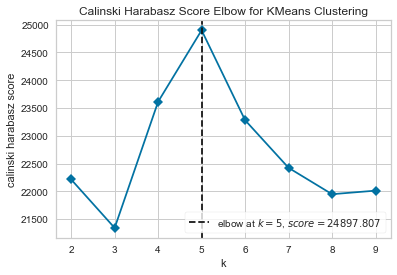

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [302]:
# Instantiate the clustering model and visualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,10), metric = 'calinski_harabasz', timings=False)

visualizer.fit(SelectOut)        # Fit the data to the visualizer

visualizer.show()  

The CH metric from this test would suggest that 5 clusters would yield the best results from our model. Another metric we can use is the Silhouette Coefficient.The score ranges from -1 to 1. Close to -1 indicates potential incorrect clustering, whereas a result near 1 would mean strong, dense clusters with points greatly separated from neighboring clusters.

For n_clusters = 2 The average silhouette_score is : 0.4251866622511939
For n_clusters = 3 The average silhouette_score is : 0.42389269372386423
For n_clusters = 4 The average silhouette_score is : 0.4109284961019103
For n_clusters = 5 The average silhouette_score is : 0.39476987859145063
For n_clusters = 6 The average silhouette_score is : 0.3772076390275192
For n_clusters = 7 The average silhouette_score is : 0.3369174046738057
For n_clusters = 8 The average silhouette_score is : 0.33491818985147254


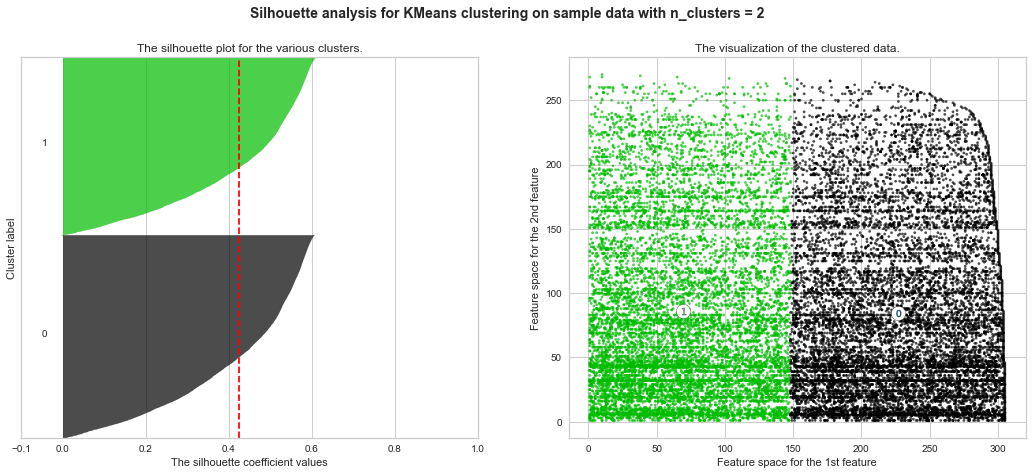

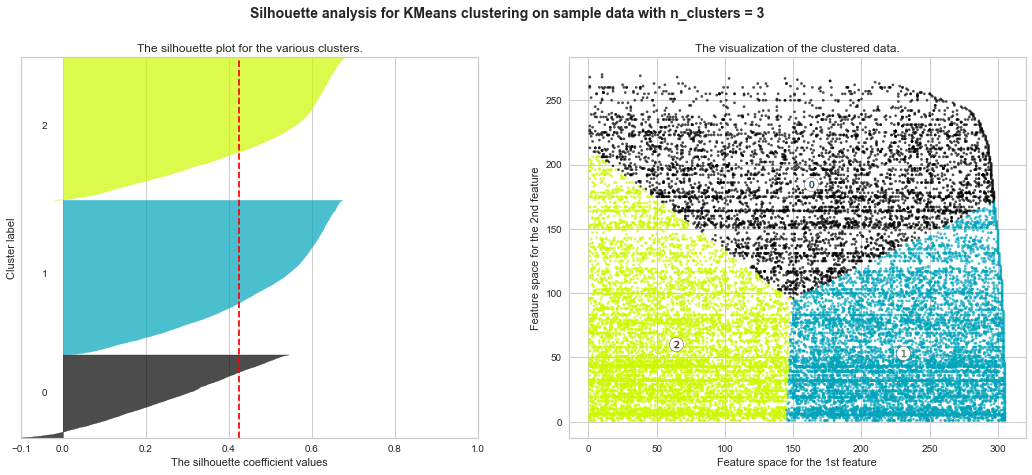

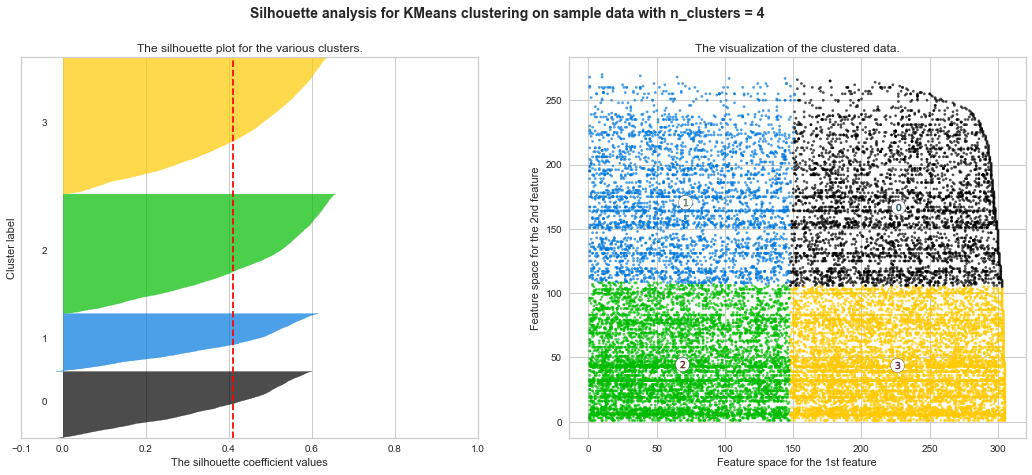

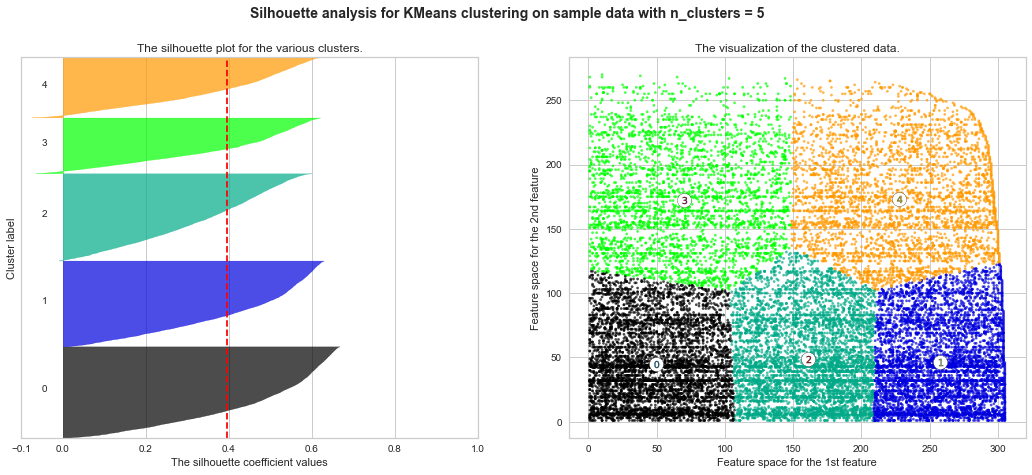

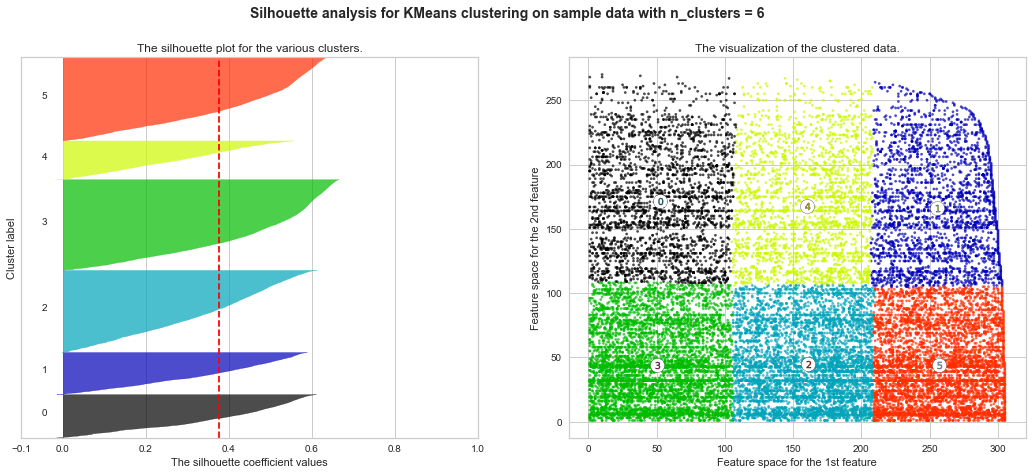

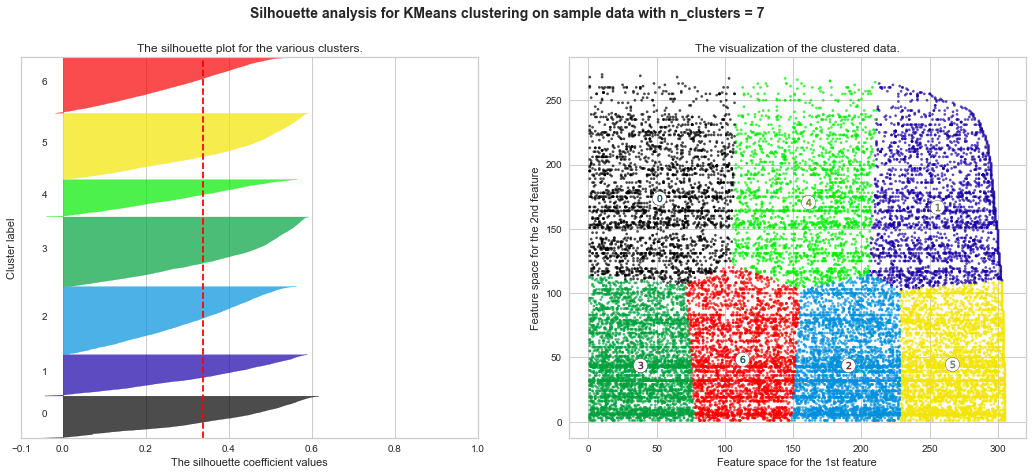

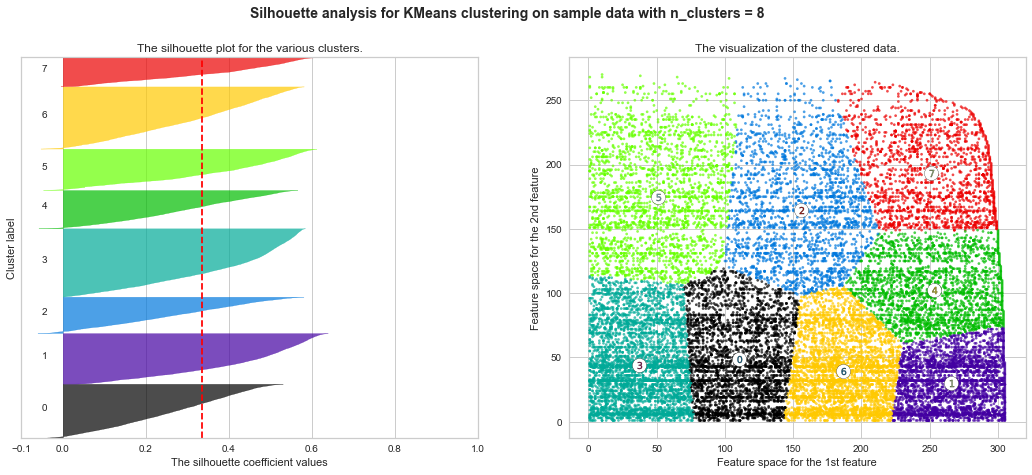

In [113]:
#Credit for this code goes to skleanr documentation 
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


range_n_clusters = [2, 3, 4, 5, 6, 7,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(SelectOut) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(SelectOut)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(SelectOut, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(SelectOut, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(SelectOut.iloc[:, -3], SelectOut.iloc[:, 3], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, -3], centers[:, 3], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[-3], c[3], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


This test would also seem to suggest 5 is an appropriate number of clusters to consider. While it does not yield the highest average score, looking at the chart on the left, each cluster is still above the average line and they all appear to be approximately equal in size. 5 clusters yields the highest score while acheiving this.

In [303]:
#instantiate kmeans model

k_means = KMeans(n_clusters= 5)

#fit the model

k_means.fit(SelectOut)

#get cluster for ea victim

clusters = k_means.predict(SelectOut)

#Center point of clusters
cl_centers = k_means.cluster_centers_

Now let's see what information about our victims we can glean from the cluters which they have been assigned. We'll being by transforming our df back to non encoded values and assigning each victim (row) to thier respective cluster

In [304]:
#Testing for model output
inv = ce_ord.inverse_transform(SelectOut)
inv.head()

Description  Inside/Outside   Weapon                     Neighborhood  \
0   Violent Crime             0.0        0  PENROSE/FAYETTE STREET OUTREACH   
2  Property Crime             0.0        0                     PERRING LOCH   
3   Violent Crime             0.0  FIREARM  COLDSTREAM HOMESTEAD MONTEBELLO   
4   Violent Crime             0.0  FIREARM                        FALLSTAFF   
5   Violent Crime             0.0        0                         BROOKLYN   

   Longitude   Latitude      Premise WeekdayName  dayofyear HourofDay  \
0 -76.651406  39.288013       STREET    Saturday        305        10   
2 -76.588293  39.353147   PORCH/DECK    Saturday        305        14   
3 -76.594384  39.322920       STREET    Saturday        305        17   
4 -76.709190  39.361468  PUBLIC AREA    Saturday        305        00   
5 -76.596062  39.232001       STREET    Saturday        305        09   

          CrimeType  
0  ROBBERY - STREET  
2           LARCENY  
3          SHOOTING  
4          HOMICIDE  
5    COMMON ASSAULT

In [305]:
inv['cluster']=clusters

In [306]:
ML=list(np.unique(clusters))

Lets look at some of the characteristics of the clusters produced by the algorythm.

In [322]:
print("Most Prevalent Crime Category for Each Cluster")
for i in range(len(np.unique(clusters))):
    print("Cluster "+str(ML[i])+": "+inv[inv.cluster == ML[i]]['Description'].value_counts().nlargest(1).index[0]+", "+str(inv[inv.cluster == ML[i]]['Description'].value_counts().nlargest(1)[0])+" total victims.")

Most Prevalent Crime Category for Each Cluster
Cluster 0: Violent Crime, 2809 total victims.
Cluster 1: Property Crime, 3074 total victims.
Cluster 2: Property Crime, 1980 total victims.
Cluster 3: Violent Crime, 2903 total victims.
Cluster 4: Property Crime, 1907 total victims.


In [329]:
print("Most Prevalent Crime Type for Each Cluster")
for i in range(len(np.unique(clusters))):
    print("Cluster "+str(ML[i])+": "+inv[inv.cluster == ML[i]]['CrimeType'].value_counts().nlargest(1).index[0]+", "+str(inv[inv.cluster == ML[i]]['CrimeType'].value_counts().nlargest(1)[0])+" total victims.")

Most Prevalent Crime Type for Each Cluster
Cluster 0: COMMON ASSAULT, 1159 total victims.
Cluster 1: LARCENY, 1256 total victims.
Cluster 2: LARCENY, 781 total victims.
Cluster 3: COMMON ASSAULT, 1212 total victims.
Cluster 4: LARCENY, 721 total victims.


In [334]:
print("Most Prevalent Crime Type for Each Cluster, (excluding larceny and common assault)")
for i in range(len(np.unique(clusters))):
    print("Cluster "+str(ML[i])+": "+inv[inv.cluster == ML[i]]['CrimeType'].value_counts().index[2]+", "+str(inv[inv.cluster == ML[i]]['CrimeType'].value_counts()[2])+" total victims.")

Most Prevalent Crime Type for Each Cluster, (excluding larceny and common assault)
Cluster 0: AGG. ASSAULT, 880 total victims.
Cluster 1: AGG. ASSAULT, 710 total victims.
Cluster 2: AGG. ASSAULT, 532 total victims.
Cluster 3: AGG. ASSAULT, 894 total victims.
Cluster 4: BURGLARY, 453 total victims.


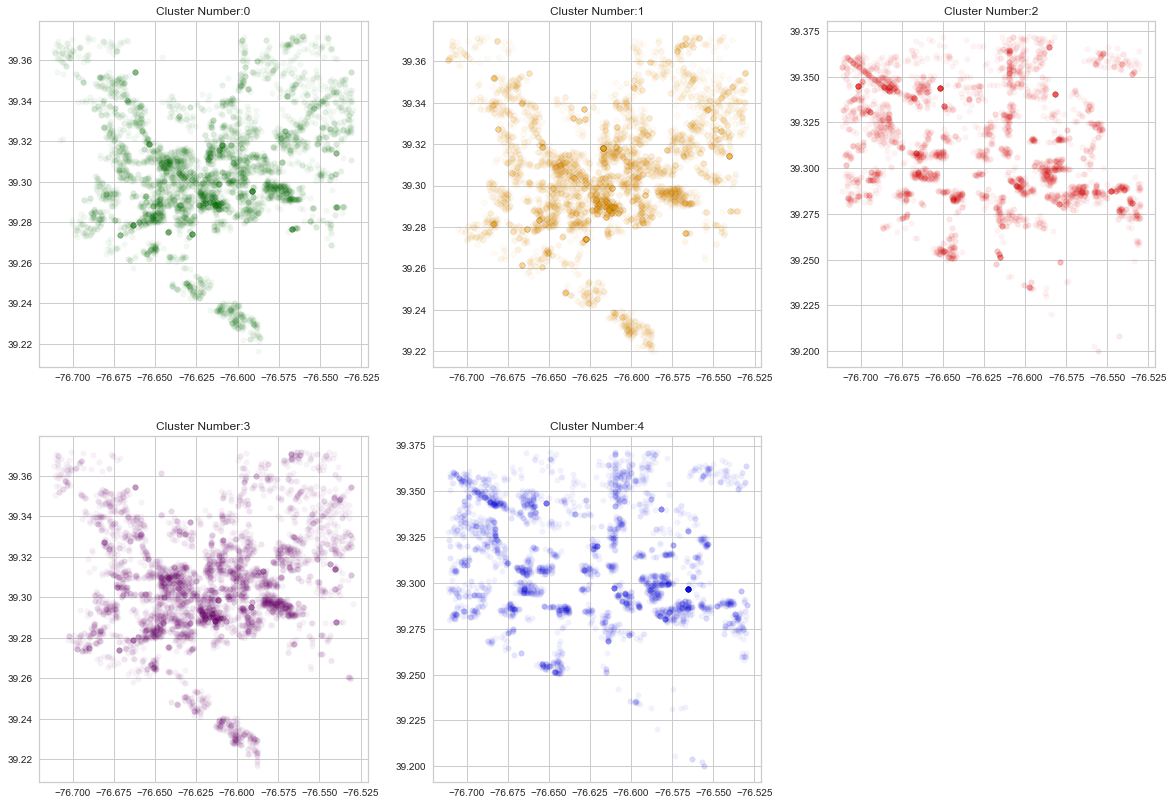

In [407]:
fig=plt.figure(figsize=(20,14))
columns = 3
rows = 2
colors=['blue','green','orange','red','purple','blue']
for i in range(1,6):
    fig.add_subplot(rows, columns, i)
    plt.scatter(inv[inv['cluster']==(i-1)]['Longitude'], inv[inv['cluster']==(i-1)]['Latitude'], marker='o',c=colors[i], alpha=.05, s=30, edgecolor='k')
    plt.title("Cluster Number:"+str(i-1))
### what you want you can plot  
plt.show()

As we can see above, clusters 1 and 4 appear to be comprised of victims of violent crime. The geographic concentration of thier occurance also is much more clustered within the center of the city. Clusters 3 and 5 are more property crime based and show a much more spread out geo location on the outskirts of the city. Cluster 2 is unqique in the fact that it is mosty highly concetrated in property crime occurance count (nearly twice the numbers of 3 and 5).

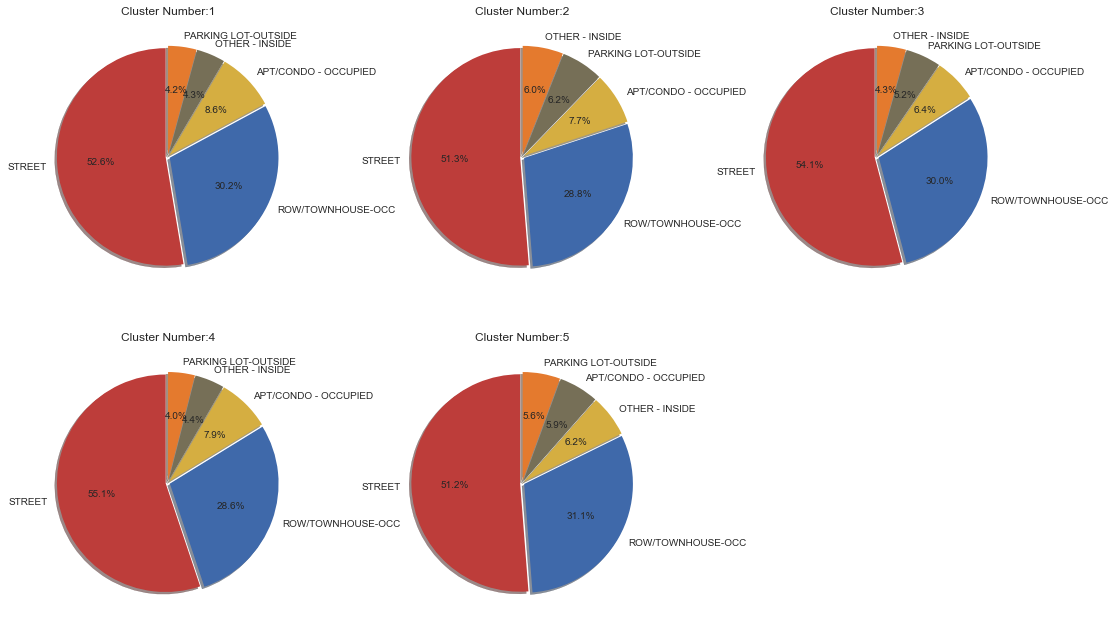

In [397]:


fig=plt.figure(figsize=(18,11))
columns = 3
rows = 2
color=['#BD3D3A', '#3F69AA', '#D5AE41', '#766F57','#E47A2E',"#006E6D",'#7F4145','#223A5E',"#9C9A40"]
explode = (0.02, .02, .02, .02,.02)
for i in range(1,6):
    types = list(inv[inv['cluster']==(i-1)]['Premise'].value_counts().nlargest(5).index)
    sizes = list(inv[inv['cluster']==(i-1)]['Premise'].value_counts().nlargest(5))
    fig.add_subplot(rows, columns, i)
    
    plt.pie(sizes, labels=types,explode=explode,autopct='%1.1f%%',shadow=True, startangle=90,colors=color)
    plt.title("Cluster Number:"+str(i))
plt.show()


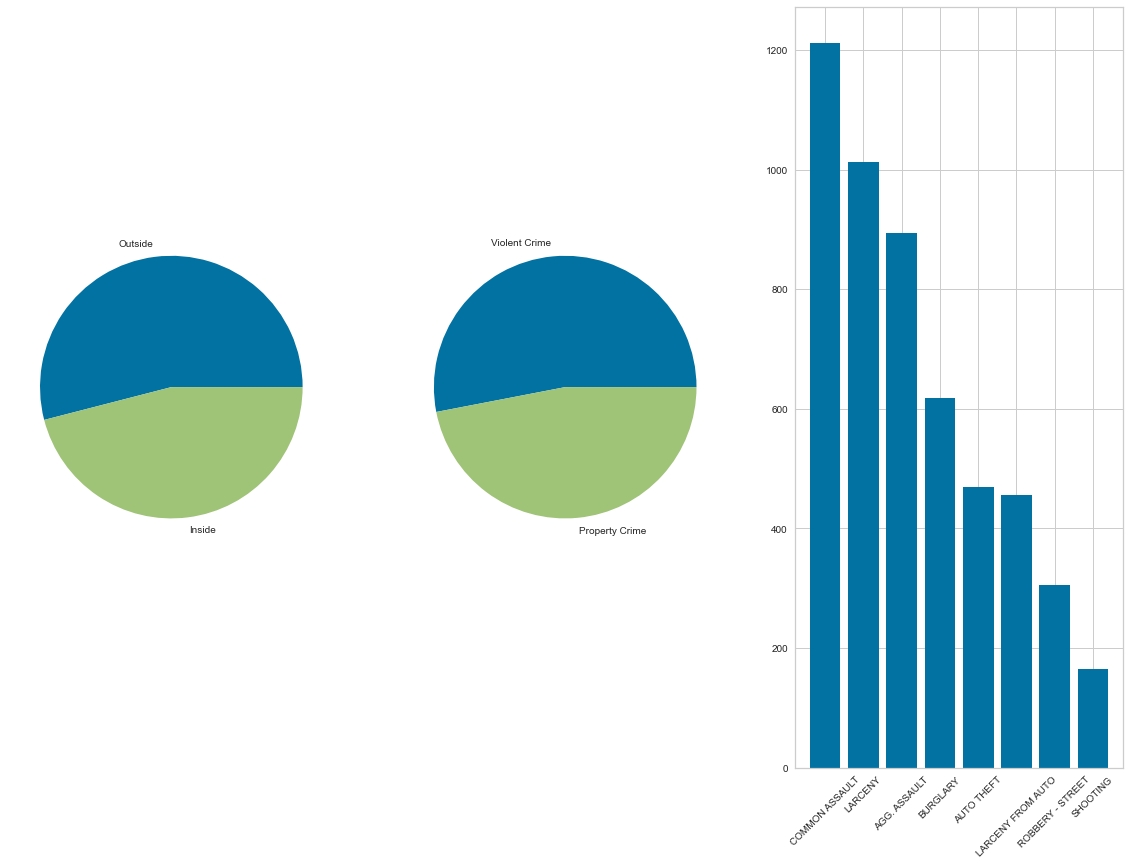

In [439]:
fig=plt.figure(figsize=(20,14))

plt.subplot(131)
pie = plt.pie(list(inv[inv['cluster']==(3)]['Inside/Outside'].value_counts()),labels=['Outside','Inside'])
plt.subplot(132)

pie = plt.pie(list(inv[inv['cluster']==(3)]['Description'].value_counts()),labels=list(inv[inv['cluster']==(3)]['Description'].value_counts().index))

# create second subplot on the right (1 row, 2 columns, position 2)
plt.subplot(133)
#scatter = plt.scatter(x,y,marker="o", label="Label 1",color="r")
#line = plt.plot(x,z,label="Label 2",color="g")
types = (inv[inv['cluster']==(3)]['CrimeType'].value_counts().nlargest(8).index)
sizes = (inv[inv['cluster']==(3)]['CrimeType'].value_counts().nlargest(8))
plt.xticks(rotation=45)

bar = plt.bar(types,sizes)

#plt.legend()
plt.show()


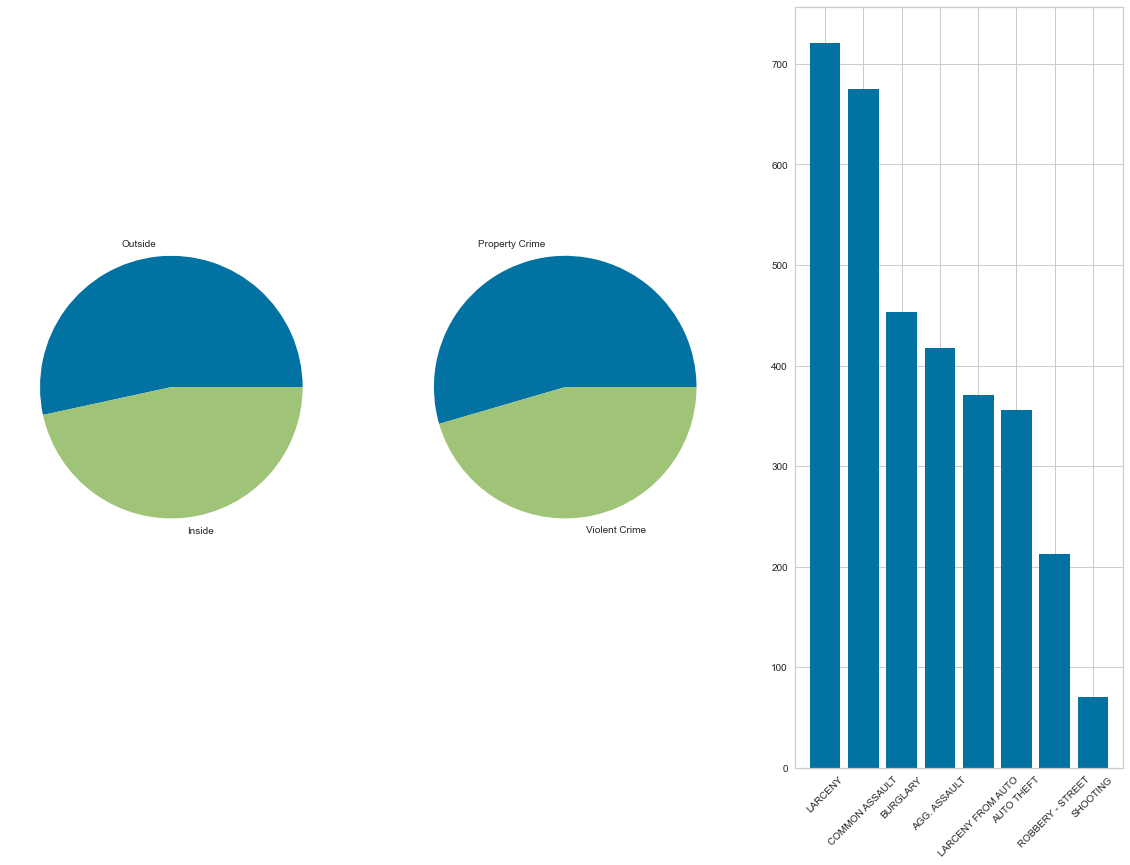

In [440]:
fig=plt.figure(figsize=(20,14))

plt.subplot(131)
pie = plt.pie(list(inv[inv['cluster']==(4)]['Inside/Outside'].value_counts()),labels=['Outside','Inside'])
plt.subplot(132)

pie = plt.pie(list(inv[inv['cluster']==(4)]['Description'].value_counts()),labels=list(inv[inv['cluster']==(4)]['Description'].value_counts().index))

# create second subplot on the right (1 row, 2 columns, position 2)
plt.subplot(133)
#scatter = plt.scatter(x,y,marker="o", label="Label 1",color="r")
#line = plt.plot(x,z,label="Label 2",color="g")
types = (inv[inv['cluster']==(4)]['CrimeType'].value_counts().nlargest(8).index)
sizes = (inv[inv['cluster']==(4)]['CrimeType'].value_counts().nlargest(8))
plt.xticks(rotation=45)

bar = plt.bar(types,sizes)

#plt.legend()
plt.show()


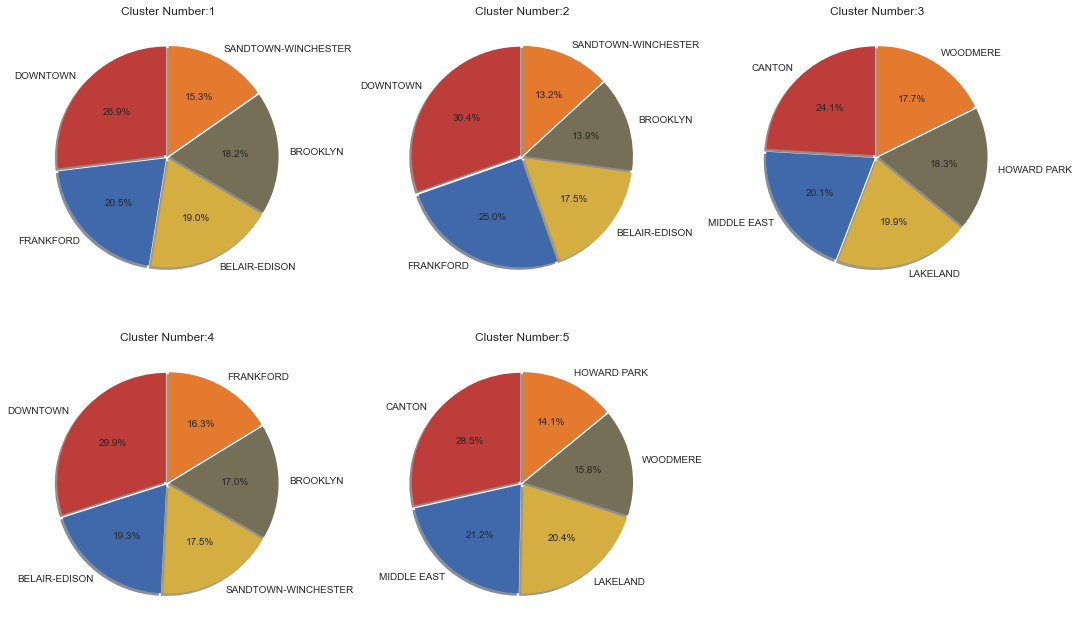

In [457]:


fig=plt.figure(figsize=(18,11))
columns = 3
rows = 2
color=['#BD3D3A', '#3F69AA', '#D5AE41', '#766F57','#E47A2E',"#006E6D",'#7F4145','#223A5E',"#9C9A40"]
explode = (0.02, .02, .02, .02,.02)
for i in range(1,6):
    types = list(inv[inv['cluster']==(i-1)]['Neighborhood'].value_counts().nlargest(5).index)
    sizes = list(inv[inv['cluster']==(i-1)]['Neighborhood'].value_counts().nlargest(5))
    fig.add_subplot(rows, columns, i)
    
    plt.pie(sizes, labels=types,explode=explode,autopct='%1.1f%%',shadow=True, startangle=90,colors=color)
    plt.title("Cluster Number:"+str(i))
plt.show()


# Joining Census Info

In an attempt to get more distinct clusters from which we can derive additional information, we will now join demographic data to the crime data. Some additional feature engineering should also help. Many of the steps below are data prep and can be skipped over. We essentially turn out victim locations into points, which we then join the neighborhood census data to, based upon which neihborhood polygon boundary they fall inside of.

In [458]:
#import grodataframe which contain CSA info for vital signs join
BaltimoreCommunities = gpd.read_file('https://data.baltimorecity.gov/api/geospatial/peh2-3qyi?method=export&format=Shapefile')
BaltimoreCommunities.head(1)

age18_16  age24_16   age5_16  age64_16   age65_16           csa2010  \
0  12.123131  6.321257  7.930073   61.4264  12.199139  Harford/Echodale   

       fam16  female10   femhhs16  hh25inc16  hh40inc16  hh60inc16  hh75inc16  \
0  26.726998    8875.0  38.882619  20.844646  14.162896  21.628959  11.342383   

   hhchpov16    hhm7516   hhpov16   hhs16  hhsize16  male10        mhhi16  \
0  18.549157  32.021116  8.983385  6630.0     2.336  7964.0  54464.962264   

   objectid  p2more16      paa16    pasi16   phisp16    ppac16   pwhite16  \
0      25.0  1.380796  52.368888  0.595389  3.318976  0.247023  42.088928   

   racdiv16    shape_area  shape_leng   tpop10  \
0  55.81348  6.536004e+07  40019.1854  16839.0   

                                            geometry  
0  POLYGON ((-76.52969 39.35653, -76.52974 39.356...

In [459]:
#import grodataframe which contain CSA info for vital signs join
BaltimoreCommunities2 = pd.read_csv('https://data.baltimorecity.gov/api/views/2ktz-dadz/rows.csv?accessType=DOWNLOAD')
BaltimoreCommunities2.head(1)


the_geom  OBJECTID  \
0  MULTIPOLYGON (((-76.52969396034 39.35653169125...        25   

  Community Statistical Area (CSA)  Total Population (2010)  \
0                 Harford/Echodale                    16839   

   Total Male Population (2010)  Total Female Population (2010)  \
0                          7964                            8875   

   Percent of Residents - Black/African-American  \
0                                      52.368888   

   Percent of Residents - White/Caucasian  Percent of Residents - Asian  \
0                               42.088928                      0.595389   

   Percent of Residents - Two or More Races  \
0                                  1.380796   

   Percent of residents - All Other Races  Percent of Residents - Hispanic  \
0                                0.247023                         3.318976   

   Racial Diversity Index  Percent of Population Under 5 Years  \
0                55.81348                             7.930073   

   Percent of Population 5-17 Years Old  \
0                             12.123131   

   Percent of Population 18-24 Years Old  \
0                               6.321257   

   Percent of Population 25-64 Years Old  \
0                                61.4264   

   Percent of Population 65 Years and Older  Total Number of Households  \
0                                 12.199139                        6630   

   Percent of Female-Headed Households with Children Under 18  \
0                                          38.882619            

   Percent of Households with Children Under 18  Average Household Size  \
0                                     26.726998                   2.336   

   Median Household Income  Percent of Households Earning Less than $25,000  \
0             54464.962264                                        20.844646   

   Percent of Households Earning $25,000 to $40,000  \
0                                         14.162896   

   Percent of Households Earning $40,000 to $60,000  \
0                                         21.628959   

   Percent of Households Earning $60,000 to $75,000  \
0                                         11.342383   

   Percent of Households Earning Over $75,000  \
0                                   32.021116   

   Percent of Family Households Living Below the Poverty Line  \
0                                           8.983385            

   Percent of Children Living Below the Poverty Line   Shape__Area  \
0                                          18.549157  6.536004e+07   

   Shape__Length  
0     40019.1854

In [460]:
BaltimoreCommunitiesFinal = pd.merge(BaltimoreCommunities2, BaltimoreCommunities.filter(['csa2010', 'geometry']), left_on=["Community Statistical Area (CSA)"], right_on=["csa2010"])


In [461]:
BaltimoreCommunitiesFinal= gpd.GeoDataFrame(BaltimoreCommunitiesFinal, geometry='geometry')


<AxesSubplot:>

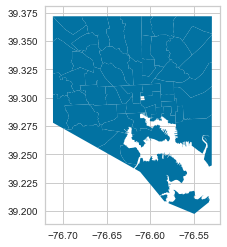

In [516]:
BaltimoreCommunitiesFinal.plot()

In [463]:
BaltimoreCommunitiesFinal.columns

Index(['the_geom', 'OBJECTID', 'Community Statistical Area (CSA)',
       'Total Population (2010)', 'Total Male Population (2010)',
       'Total Female Population (2010)',
       'Percent of Residents - Black/African-American',
       'Percent of Residents - White/Caucasian',
       'Percent of Residents - Asian',
       'Percent of Residents - Two or More Races',
       'Percent of residents - All Other Races',
       'Percent of Residents - Hispanic', 'Racial Diversity Index',
       'Percent of Population Under 5 Years',
       'Percent of Population 5-17 Years Old',
       'Percent of Population 18-24 Years Old',
       'Percent of Population 25-64 Years Old',
       'Percent of Population 65 Years and Older',
       'Total Number of Households',
       'Percent of Female-Headed Households with Children Under 18',
       'Percent of Households with Children Under 18',
       'Average Household Size', 'Median Household Income',
       'Percent of Households Earning Less than $25,0

In [464]:
BaltimoreCommunitiesFinal=BaltimoreCommunitiesFinal.drop(['the_geom','OBJECTID','Community Statistical Area (CSA)','Shape__Area','Shape__Length'],axis=1)

In [469]:
BaltimoreCommunitiesFinal.shape

(55, 29)

In [465]:
Crime['Coordinates'] = list(zip(Crime['Longitude'], Crime['Latitude']))
Crime['Coordinates'] = Crime['Coordinates'].apply(Point)

In [466]:
geo_Crime = gpd.GeoDataFrame(Crime, geometry='Coordinates')
geo_Crime=geo_Crime.set_crs("EPSG:4326")

In [467]:
geo_Crime=geo_Crime[geo_Crime['Year'] == 2020]

In [473]:
Communitiessjoined_Crime = gpd.sjoin(BaltimoreCommunitiesFinal,geo_Crime, op='contains')
Communitiessjoined_Crime.head(3)
Communitiessjoined_Crime=Communitiessjoined_Crime.set_index(['index_right'])

## Create feature that calculates the crime rate per 1k residents for each neighborhood

In [474]:
#Find top basic count communities all crime
grouped = Communitiessjoined_Crime.groupby('csa2010').size()
CrimebyCommunity = grouped.to_frame().reset_index()
CrimebyCommunity.columns = ['Community', 'Count']

In [475]:
Communitiessjoined_Crime = pd.merge(Communitiessjoined_Crime,CrimebyCommunity, left_on=["csa2010"], right_on=["Community"])

Communitiessjoined_Crime['CrimeRate_per10'] = Communitiessjoined_Crime['Count']/Communitiessjoined_Crime['Total Population (2010)']*1000
Communitiessjoined_Crime

Total Population (2010)  Total Male Population (2010)  \
0                        16839                          7964   
1                        16839                          7964   
2                        16839                          7964   
3                        16839                          7964   
4                        16839                          7964   
...                        ...                           ...   
23849                    16643                          7506   
23850                    16643                          7506   
23851                    16643                          7506   
23852                    16643                          7506   
23853                    16643                          7506   

       Total Female Population (2010)  \
0                                8875   
1                                8875   
2                                8875   
3                                8875   
4                                8875   
...                               ...   
23849                            9137   
23850                            9137   
23851                            9137   
23852                            9137   
23853                            9137   

       Percent of Residents - Black/African-American  \
0                                          52.368888   
1                                          52.368888   
2                                          52.368888   
3                                          52.368888   
4                                          52.368888   
...                                              ...   
23849                                      84.558355   
23850                                      84.558355   
23851                                      84.558355   
23852                                      84.558355   
23853                                      84.558355   

       Percent of Residents - White/Caucasian  Percent of Residents - Asian  \
0                                   42.088928                      0.595389   
1                                   42.088928                      0.595389   
2                                   42.088928                      0.595389   
3                                   42.088928                      0.595389   
4                                   42.088928                      0.595389   
...                                       ...                           ...   
23849                                8.004634                      0.926730   
23850                                8.004634                      0.926730   
23851                                8.004634                      0.926730   
23852                                8.004634                      0.926730   
23853                                8.004634                      0.926730   

       Percent of Residents - Two or More Races  \
0                                      1.380796   
1                                      1.380796   
2                                      1.380796   
3                                      1.380796   
4                                      1.380796   
...                                         ...   
23849                                  2.646974   
23850                                  2.646974   
23851                                  2.646974   
23852                                  2.646974   
23853                                  2.646974   

       Percent of residents - All Other Races  \
0                                    0.247023   
1                                    0.247023   
2                                    0.247023   
3                                    0.247023   
4                                    0.247023   
...                                       ...   
23849                                0.335940   
23850                                0.335940   
23851                                0.335940   
23852               

In [476]:
#Check for a good join, no nulls 
Communitiessjoined_Crime=Communitiessjoined_Crime.drop(['geometry'], axis=1)
Communitiessjoined_Crime.isnull().sum()

Total Population (2010)                                       0
Total Male Population (2010)                                  0
Total Female Population (2010)                                0
Percent of Residents - Black/African-American                 0
Percent of Residents - White/Caucasian                        0
Percent of Residents - Asian                                  0
Percent of Residents - Two or More Races                      0
Percent of residents - All Other Races                        0
Percent of Residents - Hispanic                               0
Racial Diversity Index                                        0
Percent of Population Under 5 Years                           0
Percent of Population 5-17 Years Old                          0
Percent of Population 18-24 Years Old                         0
Percent of Population 25-64 Years Old                         0
Percent of Population 65 Years and Older                      0
Total Number of Households              

In [479]:
Communitiessjoined_Crime=Communitiessjoined_Crime.drop(['Community','Count','Neighborhood'],axis=1)

In [480]:
#Encode the categorical variables
ce_ord2 = ce.OrdinalEncoder(cols = ['csa2010','Description','Weapon','Premise','WeekdayName','CrimeType'])
Communitiessjoined_Crime=ce_ord2.fit_transform(Communitiessjoined_Crime)

Communitiessjoined_Crime.head(3)


C:\Users\cyeager\AppData\Local\Continuum\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Total Population (2010)  Total Male Population (2010)  \
0                    16839                          7964   
1                    16839                          7964   
2                    16839                          7964   

   Total Female Population (2010)  \
0                            8875   
1                            8875   
2                            8875   

   Percent of Residents - Black/African-American  \
0                                      52.368888   
1                                      52.368888   
2                                      52.368888   

   Percent of Residents - White/Caucasian  Percent of Residents - Asian  \
0                               42.088928                      0.595389   
1                               42.088928                      0.595389   
2                               42.088928                      0.595389   

   Percent of Residents - Two or More Races  \
0                                  1.380796   
1                                  1.380796   
2                                  1.380796   

   Percent of residents - All Other Races  Percent of Residents - Hispanic  \
0                                0.247023                         3.318976   
1                                0.247023                         3.318976   
2                                0.247023                         3.318976   

   Racial Diversity Index  Percent of Population Under 5 Years  \
0                55.81348                             7.930073   
1                55.81348                             7.930073   
2                55.81348                             7.930073   

   Percent of Population 5-17 Years Old  \
0                             12.123131   
1                             12.123131   
2                             12.123131   

   Percent of Population 18-24 Years Old  \
0                               6.321257   
1                               6.321257   
2                               6.321257   

   Percent of Population 25-64 Years Old  \
0                                61.4264   
1                                61.4264   
2                                61.4264   

   Percent of Population 65 Years and Older  Total Number of Households  \
0                                 12.199139                        6630   
1                                 12.199139                        6630   
2                                 12.199139                        6630   

   Percent of Female-Headed Households with Children Under 18  \
0                                          38.882619            
1                                          38.882619            
2                                          38.882619            

   Percent of Households with Children Under 18  Average Household Size  \
0                                     26.726998                   2.336   
1                                     26.726998                   2.336   
2                                     26.726998                   2.336   

   Median Household Income  Percent of Households Earning Less than $25,000  \
0             54464.962264                                        20.844646   
1             54464.962264                                        20.844646   
2             54464.962264                                        20.844646   

   Percent of Households Earning $25,000 to $40,000  \
0                                         14.162896   
1                                         14.162896   
2                                         14.162896   

   Percent of Households Earning $40,000 to $60,000  \
0                                         21.628959   
1                                         21.628959   
2                                         21.628959   

   Percent of Households Earning $60,000 to $75,000  \
0                                         11.342383   
1                                         11.342383   
2                     

In [481]:
#Testing for model output
inv2 = ce_ord2.inverse_transform(Communitiessjoined_Crime)
inv2.head()

Total Population (2010)  Total Male Population (2010)  \
0                    16839                          7964   
1                    16839                          7964   
2                    16839                          7964   
3                    16839                          7964   
4                    16839                          7964   

   Total Female Population (2010)  \
0                            8875   
1                            8875   
2                            8875   
3                            8875   
4                            8875   

   Percent of Residents - Black/African-American  \
0                                      52.368888   
1                                      52.368888   
2                                      52.368888   
3                                      52.368888   
4                                      52.368888   

   Percent of Residents - White/Caucasian  Percent of Residents - Asian  \
0                               42.088928                      0.595389   
1                               42.088928                      0.595389   
2                               42.088928                      0.595389   
3                               42.088928                      0.595389   
4                               42.088928                      0.595389   

   Percent of Residents - Two or More Races  \
0                                  1.380796   
1                                  1.380796   
2                                  1.380796   
3                                  1.380796   
4                                  1.380796   

   Percent of residents - All Other Races  Percent of Residents - Hispanic  \
0                                0.247023                         3.318976   
1                                0.247023                         3.318976   
2                                0.247023                         3.318976   
3                                0.247023                         3.318976   
4                                0.247023                         3.318976   

   Racial Diversity Index  Percent of Population Under 5 Years  \
0                55.81348                             7.930073   
1                55.81348                             7.930073   
2                55.81348                             7.930073   
3                55.81348                             7.930073   
4                55.81348                             7.930073   

   Percent of Population 5-17 Years Old  \
0                             12.123131   
1                             12.123131   
2                             12.123131   
3                             12.123131   
4                             12.123131   

   Percent of Population 18-24 Years Old  \
0                               6.321257   
1                               6.321257   
2                               6.321257   
3                               6.321257   
4                               6.321257   

   Percent of Population 25-64 Years Old  \
0                                61.4264   
1                                61.4264   
2                                61.4264   
3                                61.4264   
4                                61.4264   

   Percent of Population 65 Years and Older  Total Number of Households  \
0                                 12.199139                        6630   
1                                 12.199139                        6630   
2                                 12.199139                        6630   
3                                 12.199139                        6630   
4                                 12.199139                        6630   

   Percent of Female-Headed Households with Children Under 18  \
0                                          38.882619            
1                                          38.882619            
2                                          38.882619            
3     

## Dimensionality reduction becomes computationally necessary 

Considering the much larger size of this dataframe, we will have to emply dimensionality reduction in order to have a workable algorythm. We will scale the data and use PCA to convert this new dataframe into 2 principal components.

In [483]:
scaler = StandardScaler()
scaler.fit(Communitiessjoined_Crime)
CrimeScaled= scaler.transform(Communitiessjoined_Crime)

In [484]:
columnsforlater=list(Communitiessjoined_Crime.columns)

In [485]:
#Just checking
pd.DataFrame(scaler.inverse_transform(CrimeScaled))

0       1       2          3          4         5         6   \
0      16839.0  7964.0  8875.0  52.368888  42.088928  0.595389  1.380796   
1      16839.0  7964.0  8875.0  52.368888  42.088928  0.595389  1.380796   
2      16839.0  7964.0  8875.0  52.368888  42.088928  0.595389  1.380796   
3      16839.0  7964.0  8875.0  52.368888  42.088928  0.595389  1.380796   
4      16839.0  7964.0  8875.0  52.368888  42.088928  0.595389  1.380796   
...        ...     ...     ...        ...        ...       ...       ...   
23849  16643.0  7506.0  9137.0  84.558355   8.004634  0.926730  2.646974   
23850  16643.0  7506.0  9137.0  84.558355   8.004634  0.926730  2.646974   
23851  16643.0  7506.0  9137.0  84.558355   8.004634  0.926730  2.646974   
23852  16643.0  7506.0  9137.0  84.558355   8.004634  0.926730  2.646974   
23853  16643.0  7506.0  9137.0  84.558355   8.004634  0.926730  2.646974   

             7         8          9         10         11         12  \
0      0.247023  3.318976  55.813480  7.930073  12.123131   6.321257   
1      0.247023  3.318976  55.813480  7.930073  12.123131   6.321257   
2      0.247023  3.318976  55.813480  7.930073  12.123131   6.321257   
3      0.247023  3.318976  55.813480  7.930073  12.123131   6.321257   
4      0.247023  3.318976  55.813480  7.930073  12.123131   6.321257   
...         ...       ...        ...       ...        ...        ...   
23849  0.335940  3.527368  30.773026  4.274544  12.325514  26.979438   
23850  0.335940  3.527368  30.773026  4.274544  12.325514  26.979438   
23851  0.335940  3.527368  30.773026  4.274544  12.325514  26.979438   
23852  0.335940  3.527368  30.773026  4.274544  12.325514  26.979438   
23853  0.335940  3.527368  30.773026  4.274544  12.325514  26.979438   

              13         14      15         16         17     18  \
0      61.426400  12.199139  6630.0  38.882619  26.726998  2.336   
1      61.426400  12.199139  6630.0  38.882619  26.726998  2.336   
2      61.426400  12.199139  6630.0  38.882619  26.726998  2.336   
3      61.426400  12.199139  6630.0  38.882619  26.726998  2.336   
4      61.426400  12.199139  6630.0  38.882619  26.726998  2.336   
...          ...        ...     ...        ...        ...    ...   
23849  42.096727  14.323776  5461.0  50.065274  28.053470  2.520   
23850  42.096727  14.323776  5461.0  50.065274  28.053470  2.520   
23851  42.096727  14.323776  5461.0  50.065274  28.053470  2.520   
23852  42.096727  14.323776  5461.0  50.065274  28.053470  2.520   
23853  42.096727  14.323776  5461.0  50.065274  28.053470  2.520   

                 19         20         21         22         23         24  \
0      54464.962264  20.844646  14.162896  21.628959  11.342383  32.021116   
1      54464.962264  20.844646  14.162896  21.628959  11.342383  32.021116   
2      54464.962264  20.844646  14.162896  21.628959  11.342383  32.021116   
3      54464.962264  20.844646  14.162896  21.628959  11.342383  32.021116   
4      54464.962264  20.844646  14.162896  21.628959  11.342383  32.021116   
...             ...        ...        ...        ...        ...        ...   
23849  51742.828244  22.395166  13.770372  19.776598  13.752060  30.305805   
23850  51742.828244  22.395166  13.770372  19.776598  13.752060  30.305805   
23851  51742.828244  22.395166  13.770372  19.776598  13.752060  30.305805   
23852  51742.828244  22.395166  13.770372  19.776598  13.752060  30.305805   
23853  51742.828244  22.395166  13.770372  19.776598  13.752060  30.305805   

             25         26    27   28   29   30         31         32   33  \
0      8.983385  18.549157   1.0  1.0  0.0  1.0 -76.569316  39.367867  1.0   
1      8.983385  18.549157   1.0  2.0  1.0  2.0 -76.568536  39.367895  2.0   
2      8.983385  18.549157   1.0  1.0  1.0  2.0 -76.568536  39.367895  2.0   
3      8.983385  18.549157   1.0  2.0  1.0  2.0 -76.569192  39.367900  2.0   
4      8.983385  18.549157   1.0  2.0  1.0  2.0 -76.569191  39.367907  3.0   
...         

In [487]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(CrimeScaled)

PCA(n_components=2)

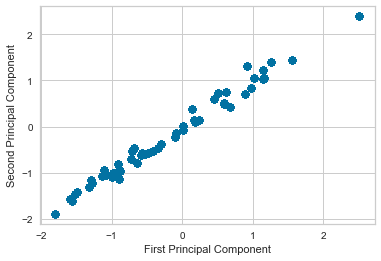

In [488]:
Crimepca = pca.transform(CrimeScaled)

plt.scatter(CrimeScaled[:,0], CrimeScaled[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [491]:
T=pd.DataFrame(scaler.inverse_transform(pca_inv))

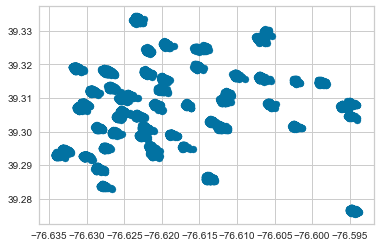

In [494]:
plt.scatter(T.iloc[:,31],T.iloc[:,32])

## Using our new 2 dimensional data set we will follow the same steps to find an optimal k and fit another model to our data

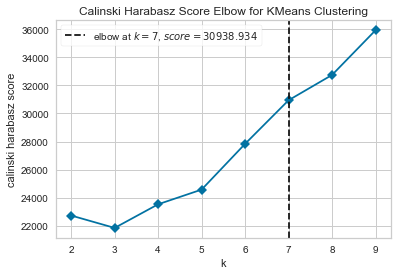

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [495]:
# Instantiate the clustering model and visualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,10), metric = 'calinski_harabasz', timings=False)

visualizer.fit(Crimepca)        # Fit the data to the visualizer

visualizer.show()  

For n_clusters = 2 The average silhouette_score is : 0.47442195451137015
For n_clusters = 3 The average silhouette_score is : 0.44534754277036637
For n_clusters = 4 The average silhouette_score is : 0.4283149760370101
For n_clusters = 5 The average silhouette_score is : 0.42781754298696006
For n_clusters = 6 The average silhouette_score is : 0.4684128982268252
For n_clusters = 7 The average silhouette_score is : 0.48330949153257635
For n_clusters = 8 The average silhouette_score is : 0.48595374621394005


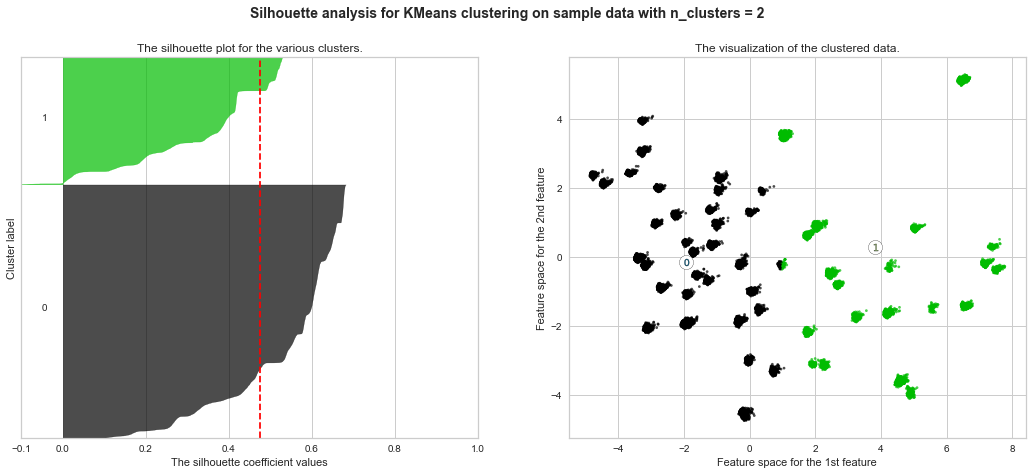

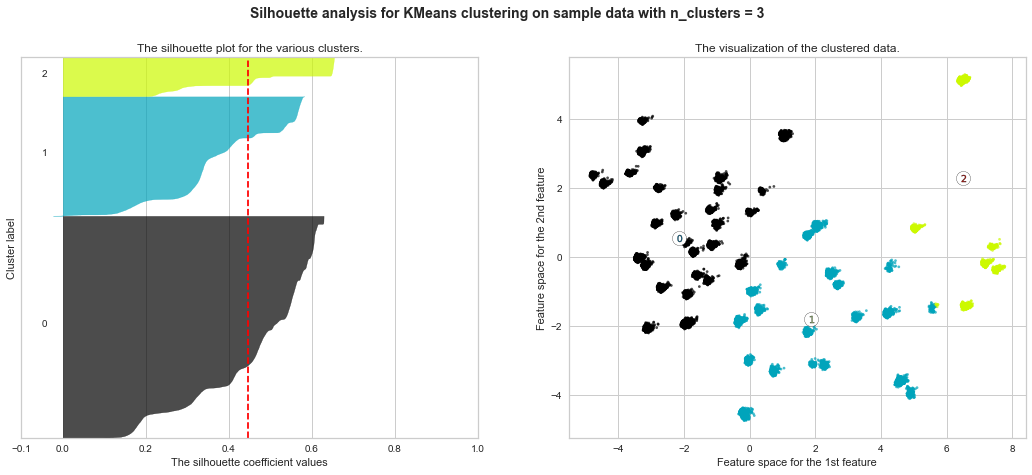

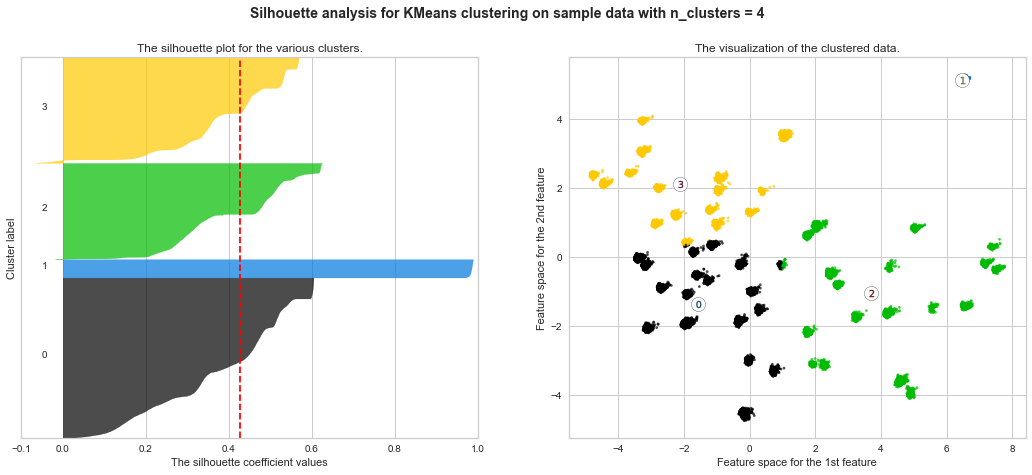

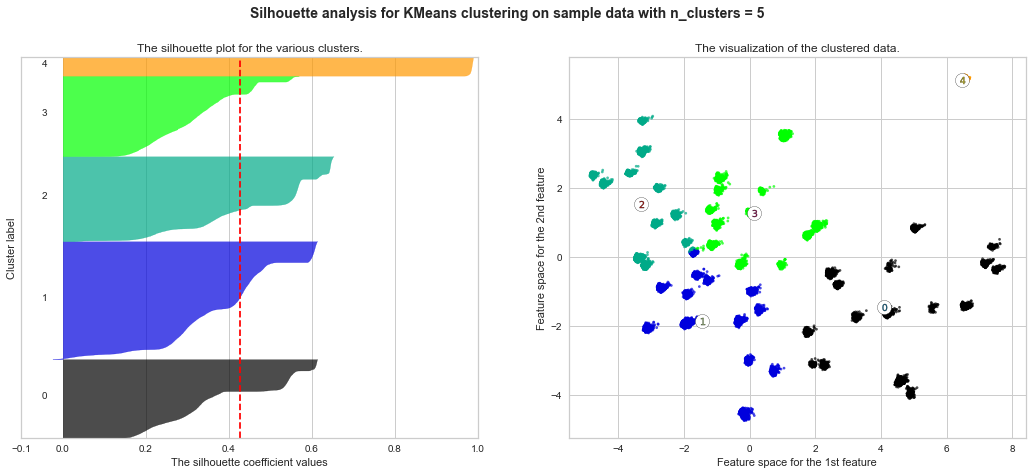

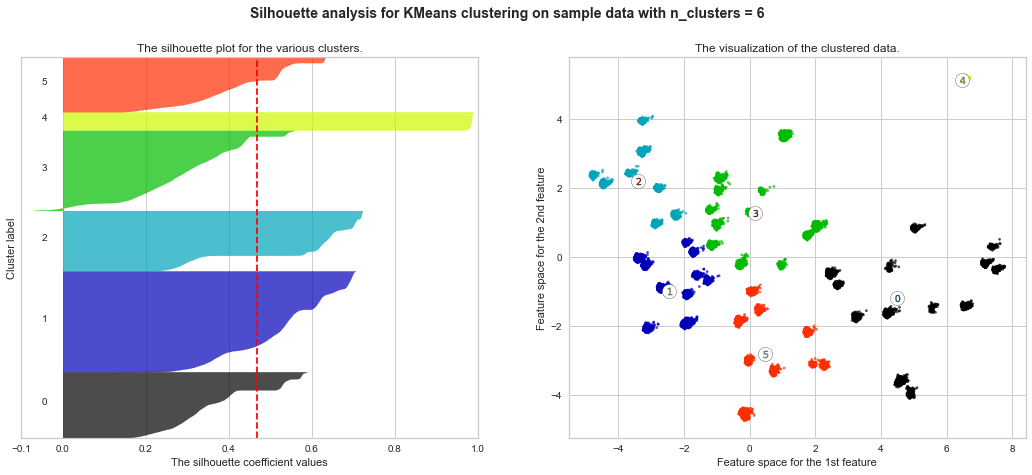

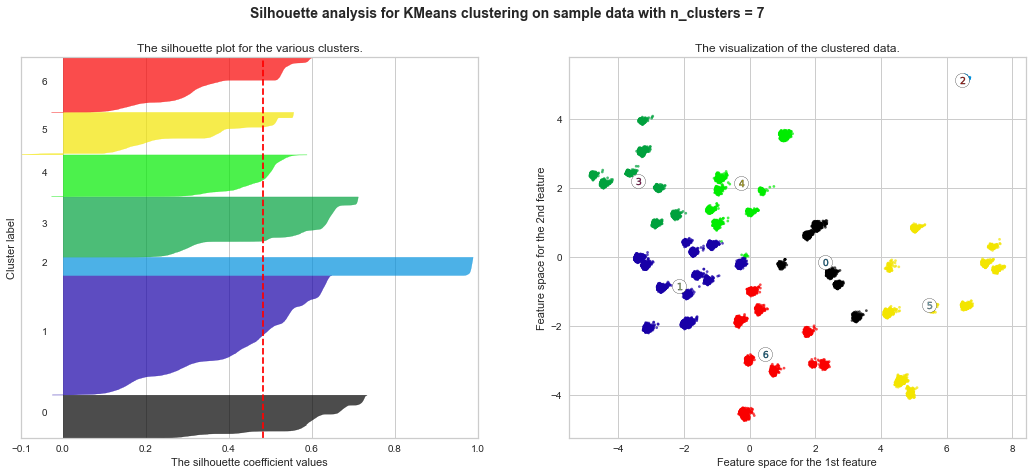

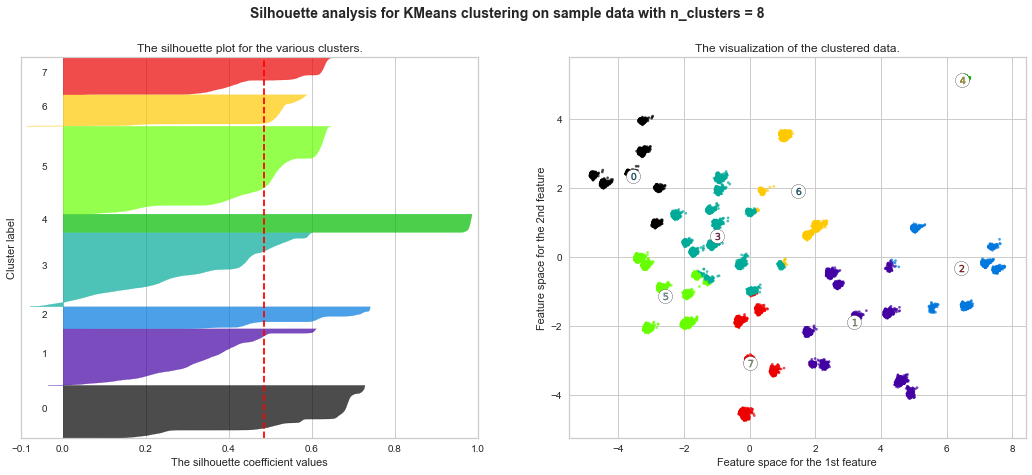

In [497]:
#Credit for this code goes to skleanr documentation 
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


range_n_clusters = [2, 3, 4, 5, 6, 7,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Crimepca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Crimepca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Crimepca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Crimepca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Crimepca[:, 0], Crimepca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


In [498]:
#We will go with 7
k_means = KMeans(n_clusters= 7)


k_means.fit(Crimepca)


clusters = k_means.predict(Crimepca)

cl_centers = k_means.cluster_centers_

In [499]:
Output=pd.DataFrame(Crimepca)
Output['cluster']=clusters

In [500]:
FinalCrime_merged = Output.merge(inv2, left_index=True, right_index=True)
FinalCrime_merged

0         1  cluster  Total Population (2010)  \
0      2.231579 -3.127198        3                    16839   
1      2.297159 -3.195822        3                    16839   
2      2.176384 -3.121631        3                    16839   
3      2.262106 -3.159219        3                    16839   
4      2.297473 -3.212730        3                    16839   
...         ...       ...      ...                      ...   
23849  0.734454 -3.215901        3                    16643   
23850  0.778335 -3.197846        3                    16643   
23851  0.744042 -3.226082        3                    16643   
23852  0.730446 -3.211316        3                    16643   
23853  0.704229 -3.224191        3                    16643   

       Total Male Population (2010)  Total Female Population (2010)  \
0                              7964                            8875   
1                              7964                            8875   
2                              7964                            8875   
3                              7964                            8875   
4                              7964                            8875   
...                             ...                             ...   
23849                          7506                            9137   
23850                          7506                            9137   
23851                          7506                            9137   
23852                          7506                            9137   
23853                          7506                            9137   

       Percent of Residents - Black/African-American  \
0                                          52.368888   
1                                          52.368888   
2                                          52.368888   
3                                          52.368888   
4                                          52.368888   
...                                              ...   
23849                                      84.558355   
23850                                      84.558355   
23851                                      84.558355   
23852                                      84.558355   
23853                                      84.558355   

       Percent of Residents - White/Caucasian  Percent of Residents - Asian  \
0                                   42.088928                      0.595389   
1                                   42.088928                      0.595389   
2                                   42.088928                      0.595389   
3                                   42.088928                      0.595389   
4                                   42.088928                      0.595389   
...                                       ...                           ...   
23849                                8.004634                      0.926730   
23850                                8.004634                      0.926730   
23851                                8.004634                      0.926730   
23852                                8.004634                      0.926730   
23853                                8.004634                      0.926730   

       Percent of Residents - Two or More Races  \
0                                      1.380796   
1                                      1.380796   
2                                      1.380796   
3                                      1.380796   
4                                      1.380796   
...                                         ...   
23849                                  2.646974   
23850                                  2.646974   
23851                                  2.646974   
23852                                  2.646974   
23853                                  2.646974   

       Percent of residents - All Other Races  \
0                                    0.247023   
1                                    0.247023   
2                     

In [505]:
ML=list(np.unique(clusters))

Lets look at some of the characteristics of the clusters produced by the algorythm.

In [506]:
print("Most Prevalent Crime Category for Each Cluster")
for i in range(len(np.unique(clusters))):
    print("Cluster "+str(ML[i])+": "+FinalCrime_merged[FinalCrime_merged.cluster == ML[i]]['Description'].value_counts().nlargest(1).index[0]+", "+str(FinalCrime_merged[FinalCrime_merged.cluster == ML[i]]['Description'].value_counts().nlargest(1)[0])+" total victims.")

Most Prevalent Crime Category for Each Cluster
Cluster 0: Property Crime, 1679 total victims.
Cluster 1: Property Crime, 2045 total victims.
Cluster 2: Violent Crime, 593 total victims.
Cluster 3: Property Crime, 1859 total victims.
Cluster 4: Violent Crime, 3412 total victims.
Cluster 5: Property Crime, 1423 total victims.
Cluster 6: Violent Crime, 2159 total victims.


In [507]:
print("Most Prevalent Crime Type for Each Cluster")
for i in range(len(np.unique(clusters))):
    print("Cluster "+str(ML[i])+": "+FinalCrime_merged[FinalCrime_merged.cluster == ML[i]]['CrimeType'].value_counts().nlargest(1).index[0]+", "+str(FinalCrime_merged[FinalCrime_merged.cluster == ML[i]]['CrimeType'].value_counts().nlargest(1)[0])+" total victims.")

Most Prevalent Crime Type for Each Cluster
Cluster 0: LARCENY, 717 total victims.
Cluster 1: LARCENY, 883 total victims.
Cluster 2: LARCENY, 295 total victims.
Cluster 3: LARCENY, 687 total victims.
Cluster 4: COMMON ASSAULT, 1328 total victims.
Cluster 5: LARCENY, 575 total victims.
Cluster 6: COMMON ASSAULT, 886 total victims.


In [508]:
print("Most Prevalent Crime Type for Each Cluster, (excluding larceny and common assault)")
for i in range(len(np.unique(clusters))):
    print("Cluster "+str(ML[i])+": "+FinalCrime_merged[FinalCrime_merged.cluster == ML[i]]['CrimeType'].value_counts().index[2]+", "+str(FinalCrime_merged[FinalCrime_merged.cluster == ML[i]]['CrimeType'].value_counts()[2])+" total victims.")

Most Prevalent Crime Type for Each Cluster, (excluding larceny and common assault)
Cluster 0: LARCENY FROM AUTO, 386 total victims.
Cluster 1: AGG. ASSAULT, 495 total victims.
Cluster 2: AGG. ASSAULT, 141 total victims.
Cluster 3: BURGLARY, 485 total victims.
Cluster 4: LARCENY, 1047 total victims.
Cluster 5: BURGLARY, 376 total victims.
Cluster 6: LARCENY, 598 total victims.


While the top classes above followed much the same pattern as before, the geographic distribution below is far more distinct. Let's take a closer look into this.

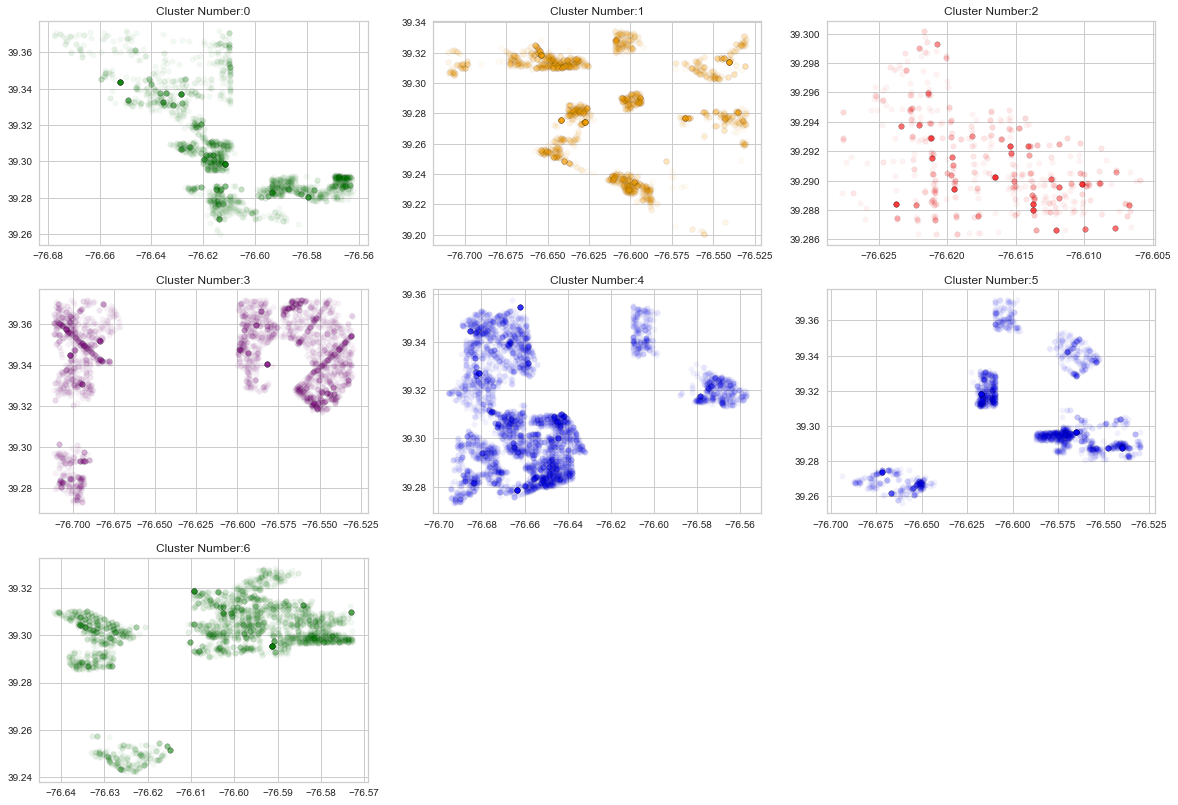

In [523]:
fig=plt.figure(figsize=(20,14))
columns = 3
rows = 3
colors=['blue','green','orange','red','purple','blue','blue','green','orange','red','purple','blue']
for i in range(1,8):

    fig.add_subplot(rows, columns, i)

    plt.scatter(FinalCrime_merged[FinalCrime_merged['cluster']==(i-1)]['Longitude'], FinalCrime_merged[FinalCrime_merged['cluster']==(i-1)]['Latitude'], marker='o',c=colors[i], alpha=.05, s=30, edgecolor='k')
    plt.title("Cluster Number:"+str(i-1))
### what you want you can plot  
plt.show()

We will create a geo dataframe and plot the crime points of each cluster on a map of baltimore's neighborhoods

In [526]:
FinalCrime_merged['Coordinates'] = list(zip(FinalCrime_merged['Longitude'], FinalCrime_merged['Latitude']))
FinalCrime_merged['Coordinates'] = FinalCrime_merged['Coordinates'].apply(Point)

In [531]:
Mapframe=gpd.GeoDataFrame(FinalCrime_merged, geometry='Coordinates')

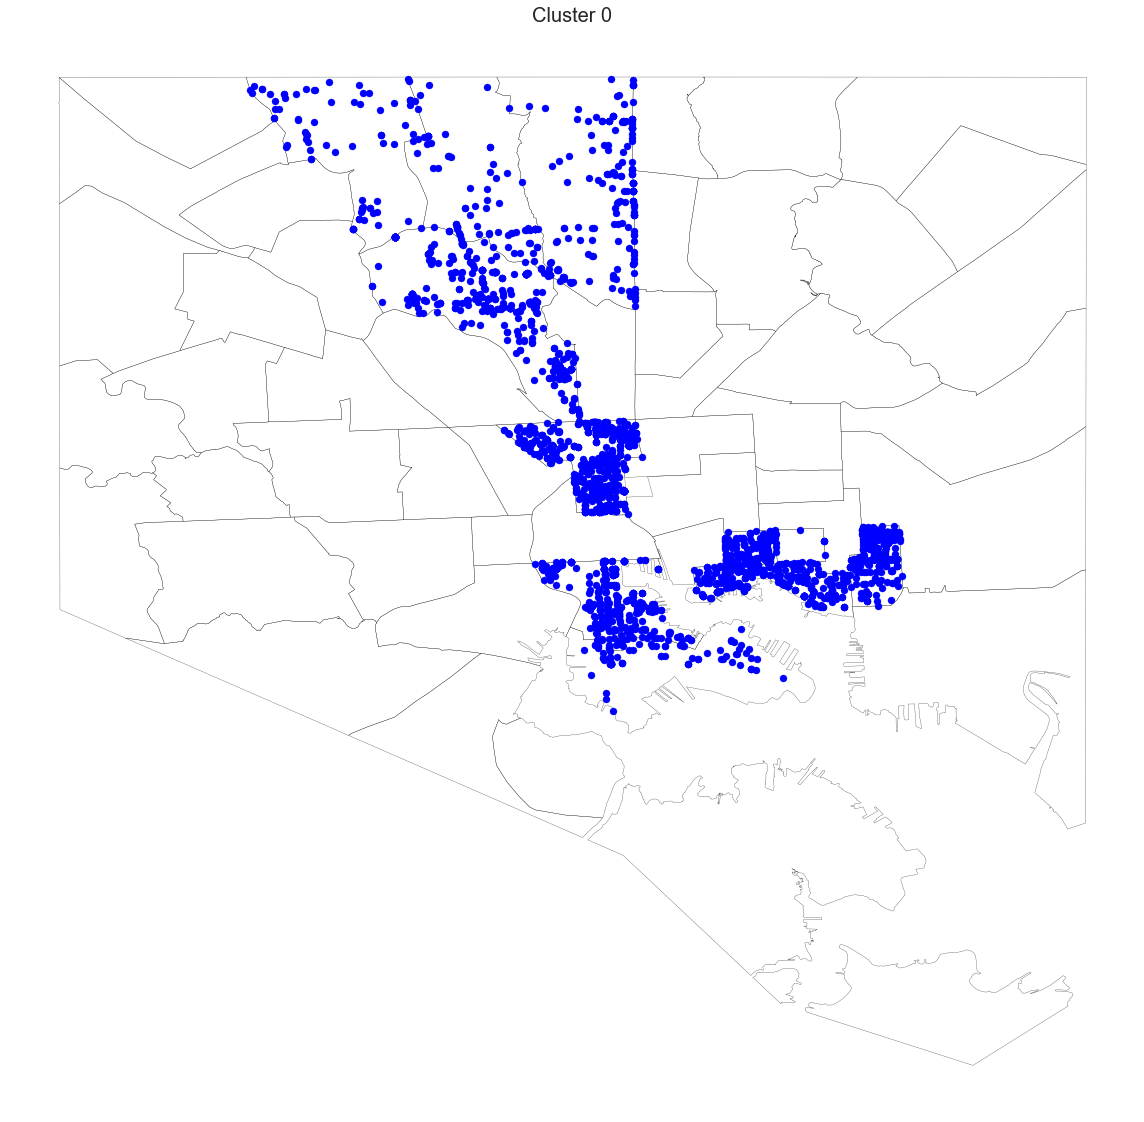

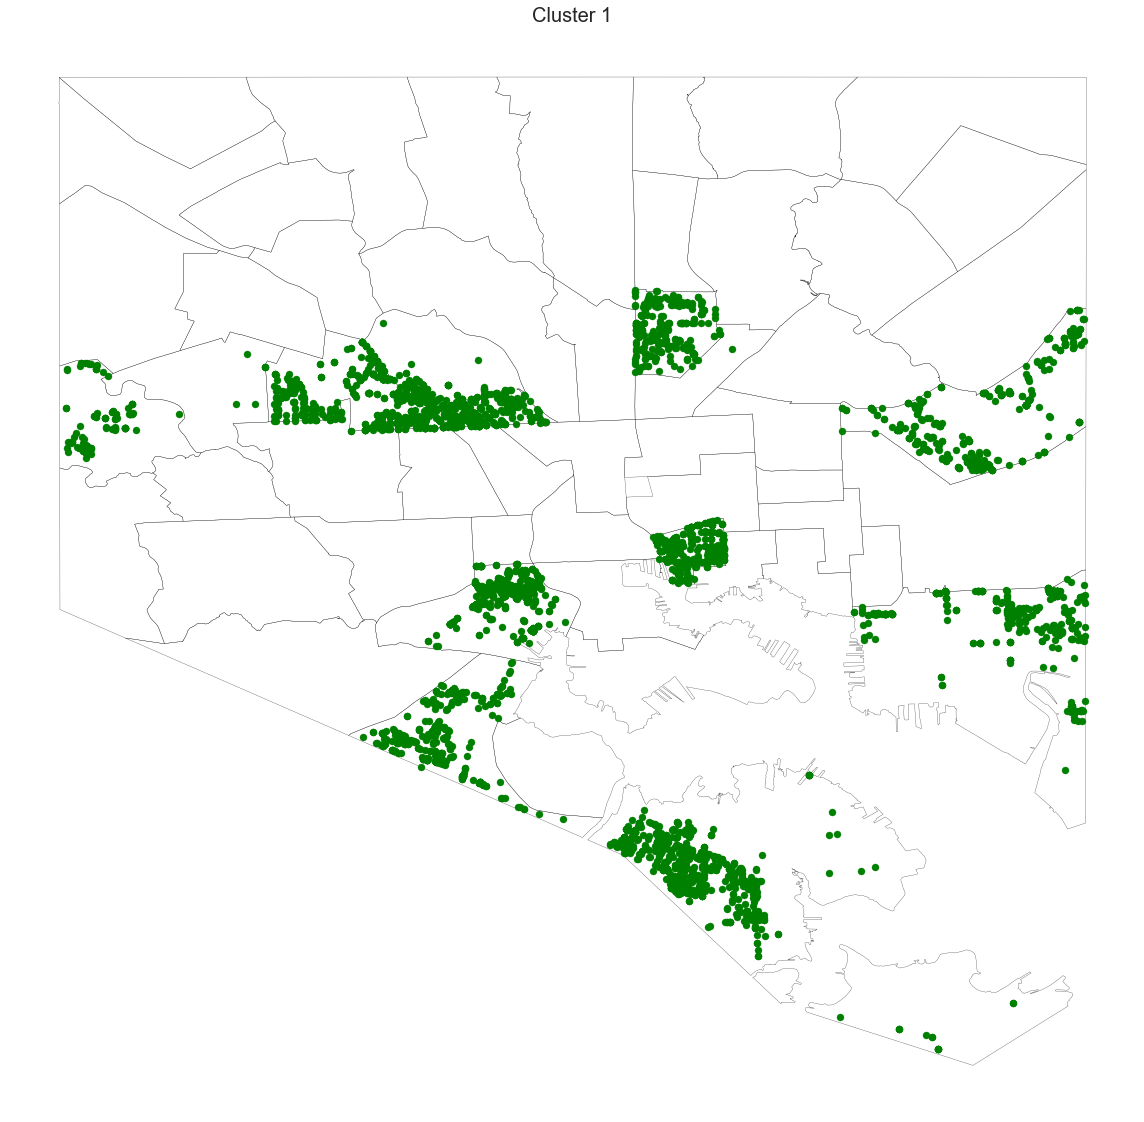

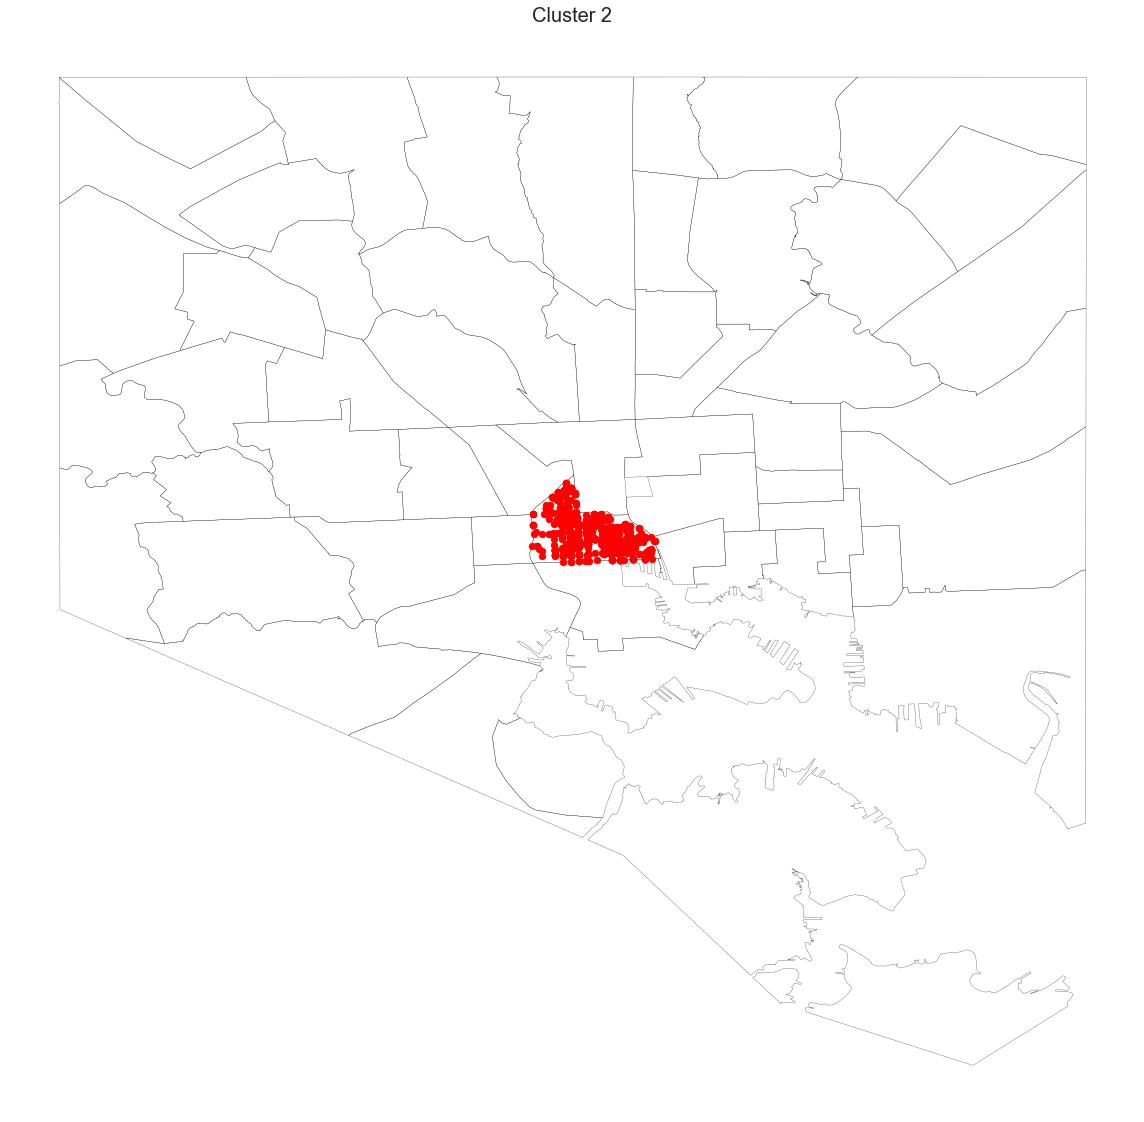

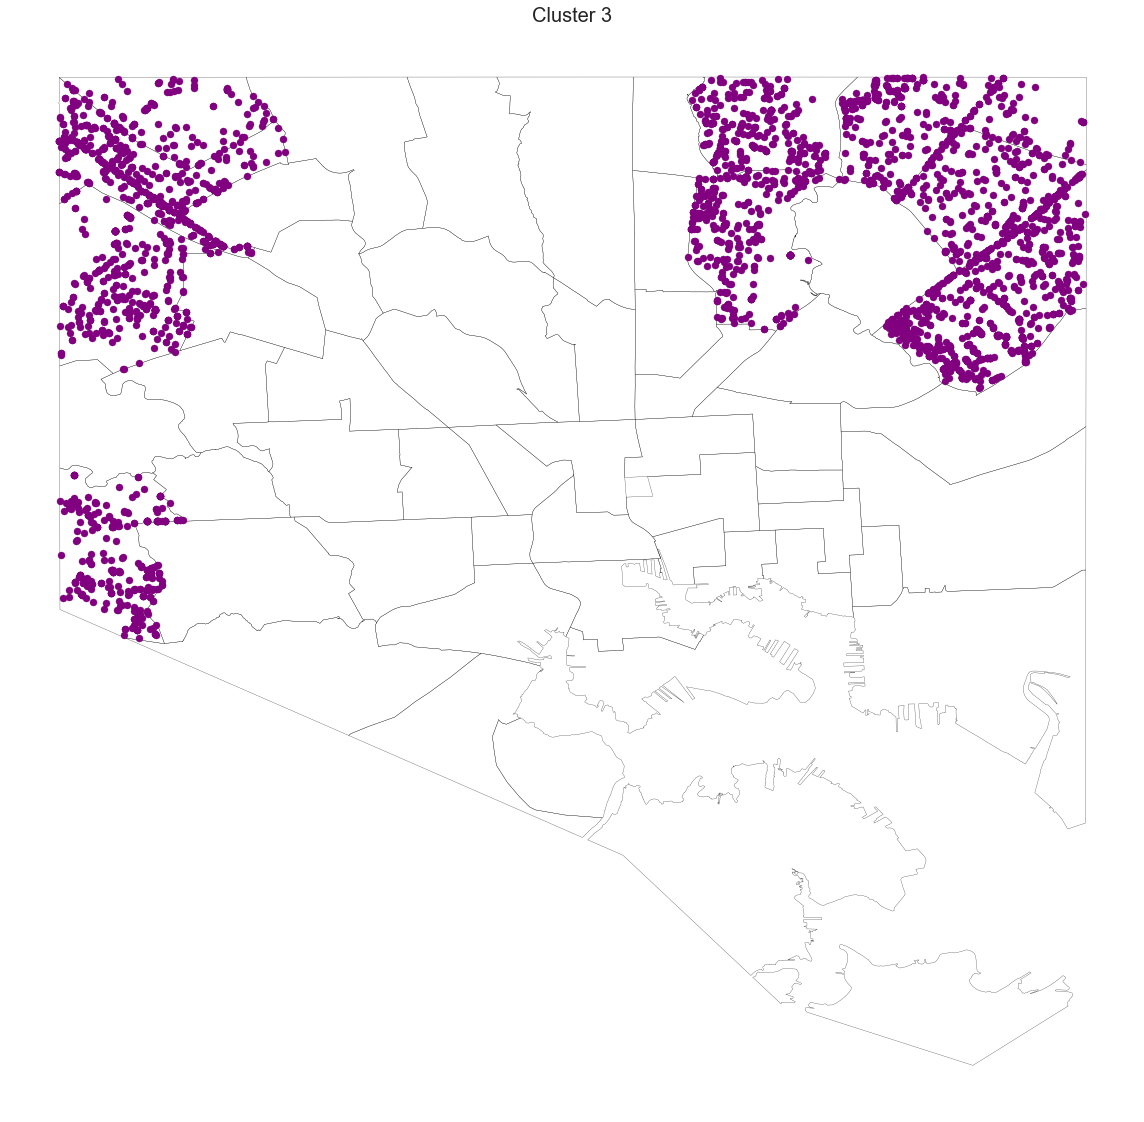

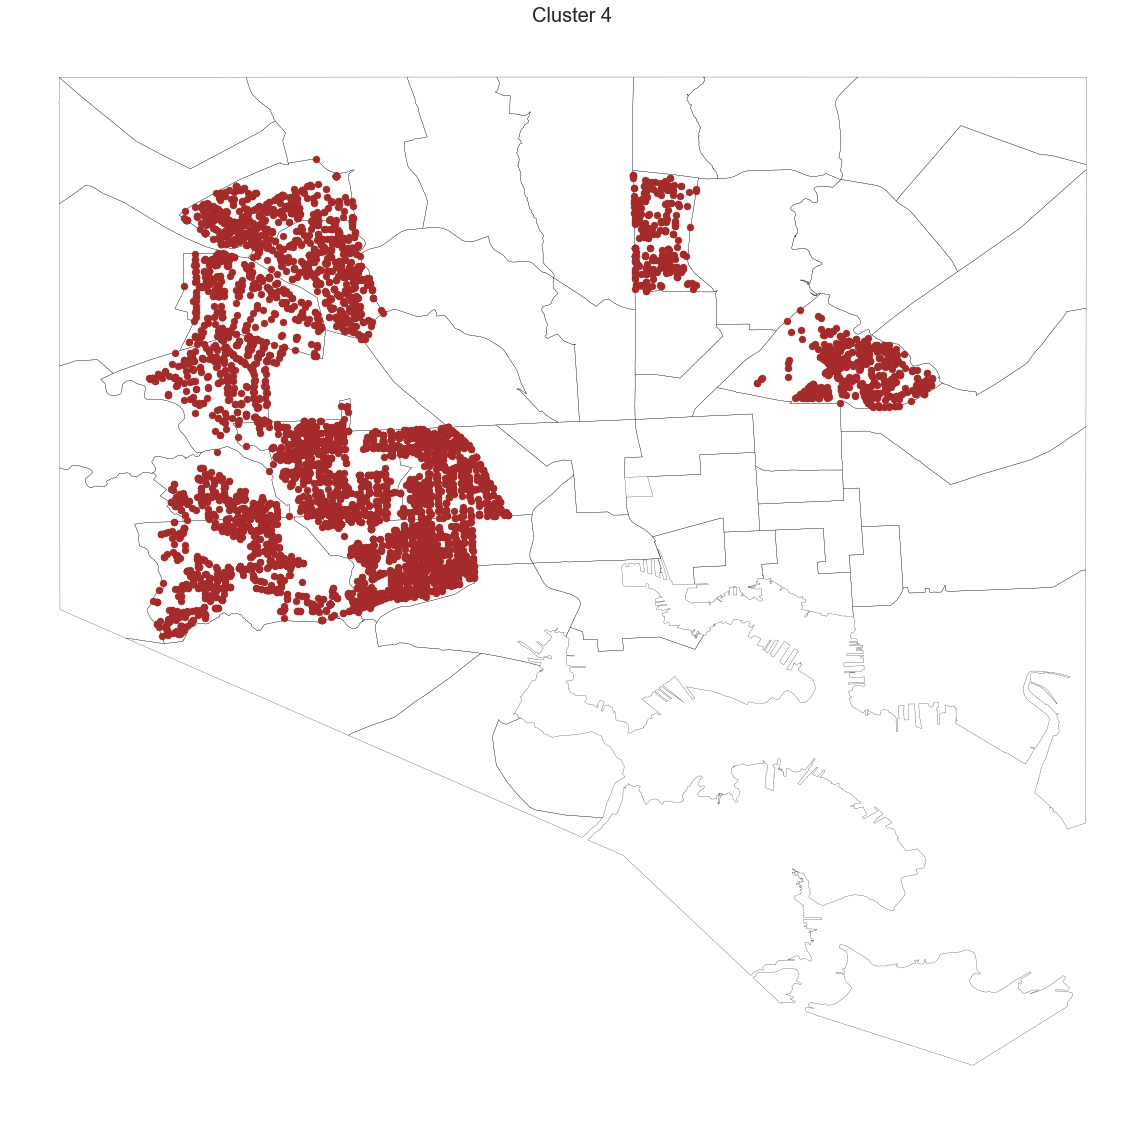

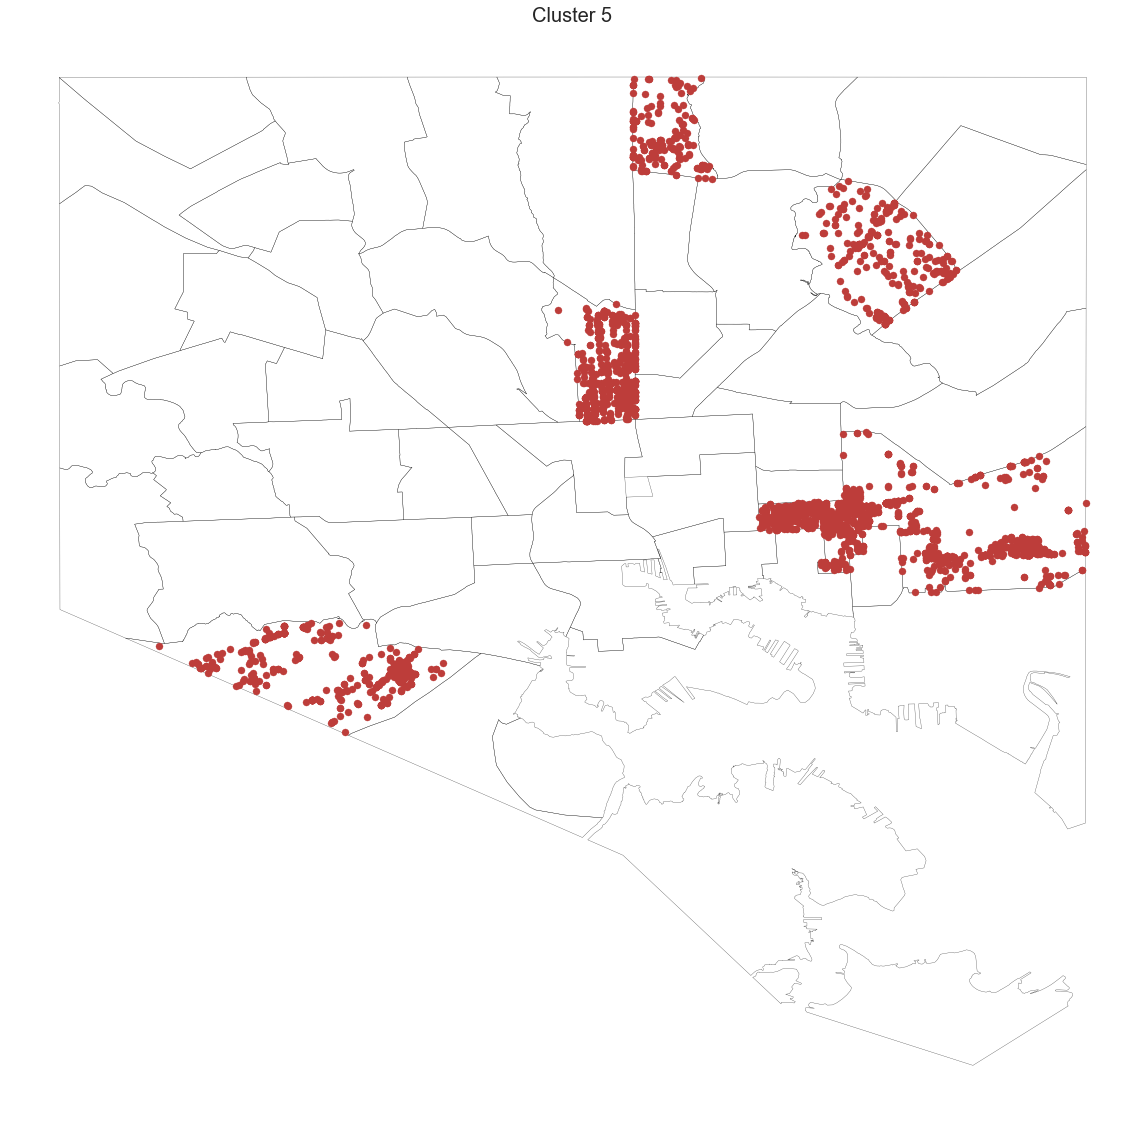

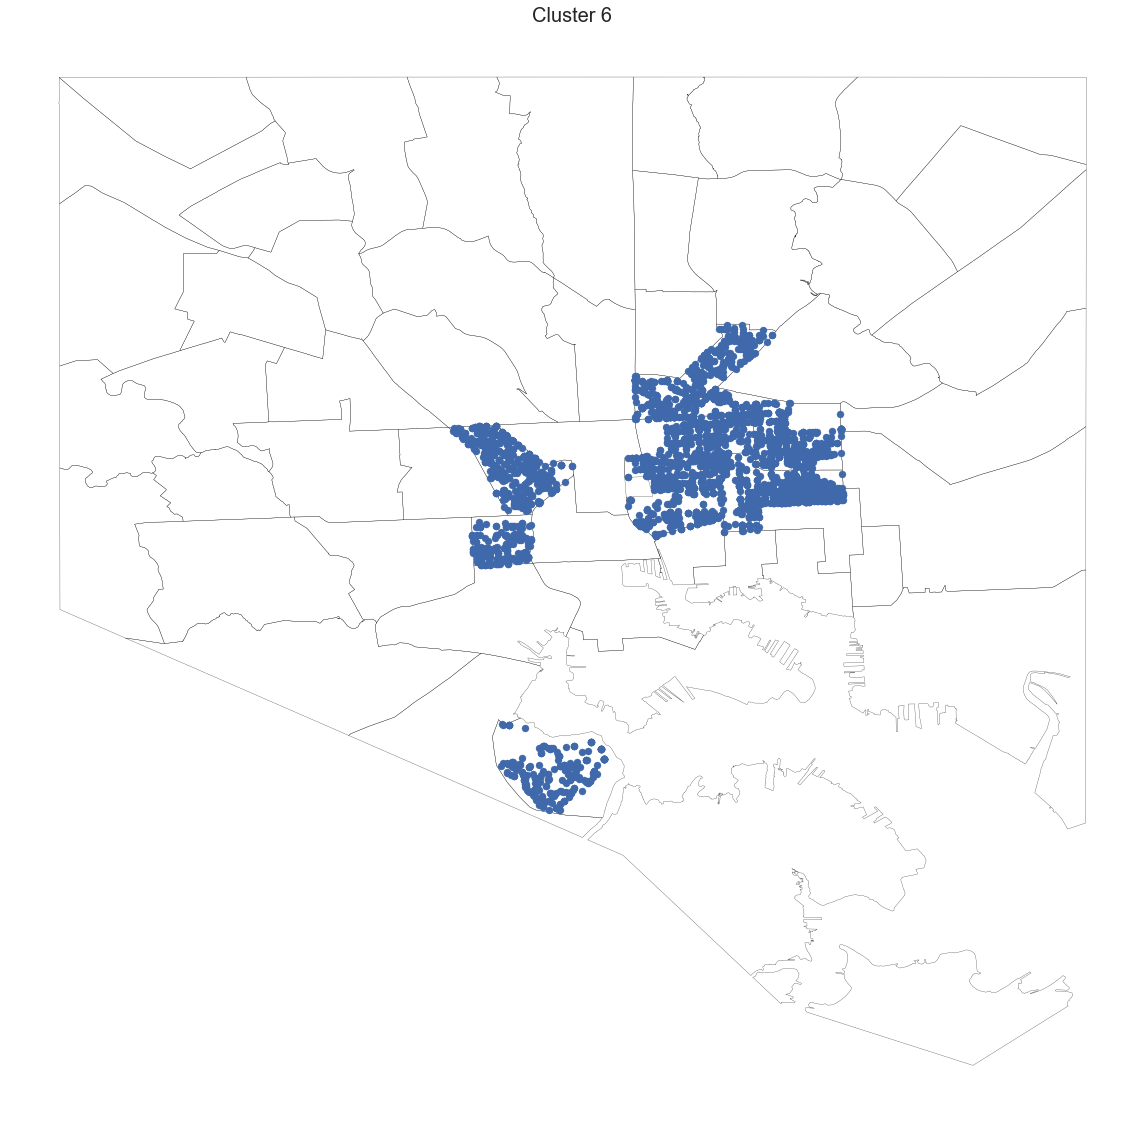

In [534]:
#Print each group separately
for i in range(len(np.unique(clusters))):
    
    

    base = BaltimoreCommunitiesFinal.plot(color='none',alpha=.8, edgecolor='black',figsize=(25, 20))

    base.set_aspect('equal')
    base.set_axis_off()

    ClusterColors = ['blue','green','red','purple','brown','#BD3D3A', '#3F69AA', '#D5AE41', '#766F57','#E47A2E',"#006E6D",'#7F4145','#223A5E',"#9C9A40",'blue','green','red','purple','brown','#BD3D3A', '#3F69AA', '#D5AE41', '#766F57','#E47A2E',"#006E6D",'#7F4145','#223A5E',"#9C9A40"]
    ax=Mapframe[Mapframe['cluster']==(i)].plot(ax=base, marker='o', color=ClusterColors[i], markersize=50);
    
    fig = ax.figure

    ax.set_title("Cluster "+str(ML[i]),fontsize=20)

    plt.show()

These patterns are extrely interesting and follow historic neighborhood boundaries and demographc groupings within the city population. For example, cluster 0 contains victims which reside within the wealthiest parts of the city. Problem areas which are know as trouble spots are also picked out, cluster 2 for example is representative of the crime problems experienced by the inner harbor tourist indisutry and weekday office communters. 

Below we will take a look at how demographics play a role in victimization. 

As stated above, cluster 0 represents the areas of the city with the greatest wealth. We see that they are primarily victims of property crime.

In [560]:
#FinalCrime_merged[FinalCrime_merged['cluster']==0]['CrimeType'].value_counts().nlargest(10)
print("The Average Median Household Income: "+str(round(FinalCrime_merged[FinalCrime_merged['cluster']==0]['Median Household Income'].mean(),2)))
print("Average Percentage of Housholds Earning more than $75k : "+str(round(FinalCrime_merged[FinalCrime_merged['cluster']==0]['Percent of Households Earning Over $75,000'].mean(),2))+"%")
print("Average Percentage of Housholds with single parent : "+str(round(FinalCrime_merged[FinalCrime_merged['cluster']==0]['Percent of Female-Headed Households with Children Under 18'].mean(),2))+"%")

print("Average Percentage of Minority Housholds: "+str(100-round(FinalCrime_merged[FinalCrime_merged['cluster']==0]['Percent of Residents - White/Caucasian'].mean(),2))+"%")

The Average Median Household Income: 74652.17
Average Percentage of Housholds Earning more than $75k : 47.84%
Average Percentage of Housholds with single parent : 20.86%
Average Percentage of Minority Housholds: 30.33%


In [554]:
print("Most common crime types in cluster 0")
FinalCrime_merged[FinalCrime_merged['cluster']==0]['CrimeType'].value_counts().nlargest(10)

Most common crime types in cluster 0


LARCENY                 717
COMMON ASSAULT          405
LARCENY FROM AUTO       386
BURGLARY                342
AUTO THEFT              230
AGG. ASSAULT            218
ROBBERY - STREET        173
ROBBERY - COMMERCIAL     66
ROBBERY - CARJACKING     57
SHOOTING                 29
Name: CrimeType, dtype: int64

Inversely, taking a look at cluster 4, these are the areas of the city which are historically the hardest hit by poverty and drug related violence. What does the demographic and crime victim breakdown tell us about this area?

In [559]:
print("The Average Median Household Income: "+str(round(FinalCrime_merged[FinalCrime_merged['cluster']==4]['Median Household Income'].mean(),2)))
print("Average Percentage of Housholds Below the Poverty Line : "+str(round(FinalCrime_merged[FinalCrime_merged['cluster']==4]['Percent of Family Households Living Below the Poverty Line'].mean(),2))+"%")
print("Average Percentage of Housholds with single parent : "+str(round(FinalCrime_merged[FinalCrime_merged['cluster']==4]['Percent of Female-Headed Households with Children Under 18'].mean(),2))+"%")
print("Average Percentage of Minority Housholds: "+str(100-round(FinalCrime_merged[FinalCrime_merged['cluster']==4]['Percent of Residents - White/Caucasian'].mean(),2))+"%")

The Average Median Household Income: 32658.55
Average Percentage of Housholds Below the Poverty Line : 25.34%
Average Percentage of Housholds with single parent : 66.21%
Average Percentage of Minority Housholds: 94.63%


In [558]:
print("Most common crime types in cluster 4")
FinalCrime_merged[FinalCrime_merged['cluster']==4]['CrimeType'].value_counts().nlargest(10)

Most common crime types in cluster 4


COMMON ASSAULT          1328
AGG. ASSAULT            1103
LARCENY                 1047
BURGLARY                 795
AUTO THEFT               667
LARCENY FROM AUTO        396
ROBBERY - STREET         288
SHOOTING                 249
ROBBERY - CARJACKING     120
HOMICIDE                 117
Name: CrimeType, dtype: int64

It is a striking difference. Household wealth, family situation, and minorty status between the two areas is sharply different. The amount of violent crime in cluster 4 is also alarmingly higher. Aggrivated assault has more than quadrupled and both shooting and homicide have made the top ten. 

# Conclusion

It is important to note and extremely obvious that the additional information provided by the demographic data which was joined to the crime victim data improved the output of the clustering model a great deal. The clusters identified in the second half of the analysis identify and fall in line with many of the patterns and ideas which city police analysts and command level staff have laid out in reports over many years. The impressive thing is that the model was able to do so without the extensive work and domain knowledge that comes along with working in Baltimore city as a public saftey officer for many years. 

Improving the model further so as to create general 'victim profiles' is something that I believe would be obtainable with additional time and information. While we were able to incorporate some demographic info, it was done only at the neighborhood level using census data. Only 55 neighborhoods exist within the city and thus each victim (though there were tens of thousands) was forced into one of these generalizations. Getting the specific person information from each victim report to fill in this information on a more granualar and accurate level (age, income, address, profession, race, gender etc) would serve to make an infinitely more detailed model and cluster output. 

Computational limitations are one potential hurdle to reaching this level of detail. Dimentionality reduction became necessary in this analysis after joining the census data. Without harnessing pca the insights gleaned fromt he second half of the project would not have been possible.

As it stands I believe that police officials, using this model, could ingest individual citizen information and make a suggestion to that person as to what steps they should take to be more safe and for what crimes they are at the greatest risk of becomming a vicitm to. 